# Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt_extent = 'LargeData'

In [3]:
print("the tensroflow version being used is {} GPU".format(tf.__version__))

the tensroflow version being used is 1.12.0 GPU


In [4]:
device = '/device:GPU:0'

If using CPU version of tensorflow change GPU to CPU in the above cell

To install tensorflow use: pip3 install tensorflow-gpu==1.12.0; however i would reccomend installing tensorflow CPU (pip3 install tensorflow==1.12.0) as the GPU version requires a CUDA installation as well 

# Import Grid Definition

This is a 2D grid definition to keep the problem simple of illustration purposes

In [5]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0

# Import Dataset 

### Read in the Simulated Dataset

In [6]:
datafl = gs.DataFile(flname='largedata.dat', griddef = griddef,
                       readfl=True)
datafl.drop('Mo')
datafl.describe()

count    3245.00000
mean        0.25328
std         0.22901
min         0.00075
25%         0.08855
50%         0.19575
75%         0.34877
max         2.00971
Name: Cu, dtype: float64

In [7]:
declus = gs.Program('declus')

In [8]:
declusparstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
largedata.dat         -file with data
1   2   3   4               -  columns for X, Y, Z, and variable
-99     1.0e21          -  trimming limits
declus_ful.sum                  -file for summary output
declus_ful.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  300.0               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
declus.run(declusparstr)

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = largedata.dat                           
 columns =            1           2           3           4
 tmin,tmax =       -99.000000    1.000000E+21
 summary file = declus_ful.sum                          
 output file = declus_ful.out                          
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =          100       10.000000      300.000000
 offsets =           20


There are     3245 data with:
  mean value            =      0.25328
  minimum and maximum   =      0.00075     2.00971
  size of data vol in X =   5088.50000
  size of data vol in Y =   2118.19922
  size of data vol in Z =    663.14954

  declustered mean      =      0.16700
  min and max weight    =      0.20279    10.07383
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.


In [9]:
declus_fl = gs.DataFile('declus_ful.out',griddef=griddef)
declus_fl

DataFile: declus_ful.out
Attributes:
x: 'X',  y: 'Y',  z: 'Z',  wts: 'Declustering Weight',  
Variables:
'Cu', 'Mo'
Grid Definitions:
125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0

In [10]:
declus_sum = gs.DataFile('declus_ful.sum') 
declus_sum.head()

Cell Size  Declustered Mean
0        0.0             0.253
1       10.0             0.253
2       12.9             0.252
3       15.8             0.251
4       18.7             0.251

In [11]:
kt3dn = gs.Program('kt3dn')
parstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
largedata_DH.dat              -file with data
1  2  3  4  5  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
10    10.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
kt3dn.out                        -file for kriged output (see GSB note)
125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0                 -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
4    40    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
1000.0  1000.0  1000.0              -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
1                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0  0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
1    0.2                         -nst, nugget effect
1    0.8  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
      100.0  100.0  100.0        -a_hmax, a_hmin, a_vert

Data spacing analysis explained:
The approximate data spacing (given a number of neighbours to use
and composite length for 3D kriging) is calculated as well as the distance to the nearest
neighbour. Results are summarized in the data spacing output file.

GSB explained:
Input and output grid files may be binary when running the program in grid mode.
This includes the optonal external and keyout files, as well as the output file. The program
assumes that a file is formatted as GSLIB-style binary (GSB) if a .gsb extension is detected.

Debugging levels explained:
0: no debugging output
3: get extra kriging information
5: get the above + GSK variance
10: get the above + kriging matrix info
Note1: idbg>=5 may involve a long run time
Note2: GSKV calculation uses search radius

Auto Search Optimization (ASO) explained:
Set min data for kriging to the negative of value
         ie: for min data = 2, set min data to -2
max data is then the lower limit for number of data
Provide a upper limit and increment
         ie: -4  8  12  1 means that
         4 is the min data for kriging
         and kriging will be performed with a max of 
         8, 9, 10, 11 and 12 data sequentially
The outputs are output as realizations from 
the lower limit to the upper limit (similar to SGSIM)

Keyout explained:
A keyout variable, matching the dimensions of the output grid, may be used to specify
whether each location should be estimated (value to keep) or unestimated (everything else). 
This has the potential to substatially increase execution speed when only interested in an
irregular sub-volume of the modeling grid. 

Invdist option explained:
Set nst to -1 for inverse distance
Inverse distance estimates are calculated with the anisotropy/angle information and weights as:
 weight(i)*=1/(h+c0(1))^(cc(1))
The ID weights are then scaled to sum to 1
"""
kt3dn.run(parstr)


Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.4.7

  data file = largedata_DH.dat                        
  columns =            1           2           3           4           5
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = kt3dn.out                               
  nx, xmn, xsiz =          125   34407.5000000000        15.0000000000000     
  ny, ymn, ysiz =           80   27407.5000000000        15.0000000000000     
  nz, zmn, zsiz =           40   607.500000000000        15.0000000000000     
  block discretization:    

In [12]:
spacfl = gs.DataFile('kt3dn_dataspacing.out')
spacfl.head()

Estimate  EstimationVariance  Distance to Nearest Neighbour  Data Spacing
0  0.141654            1.104513                      461.72238     497.18409
1  0.141654            1.104513                      451.73837     496.82908
2  0.141654            1.104513                      442.03796     496.49942
3  0.134633            1.104595                      432.64021     496.06834
4  0.142058            1.104595                      423.56529     495.71333

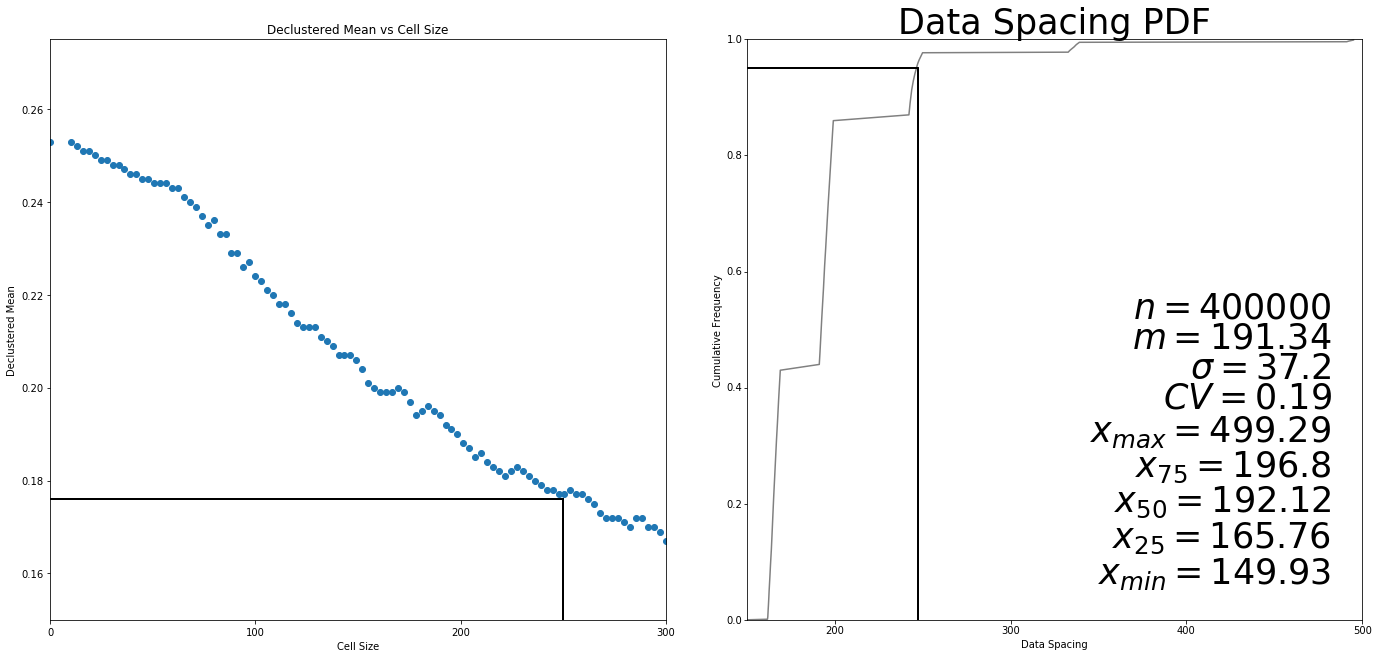

In [13]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(declus_sum.data['Cell Size'], declus_sum.data['Declustered Mean'])
ax1.set_title('Declustered Mean vs Cell Size')
ax1.set_xlabel('Cell Size')
ax1.set_ylabel('Declustered Mean')
ax1.set_xlim(0,300)
ax1.set_ylim(0.15,0.275)
ax1.plot([250, 250], [0.15, 0.176], 'k-', lw=2)
ax1.plot([0,250], [0.176,0.176], 'k-', lw=2)
gs.set_style('pt35')
gs.histplt(spacfl,var='Data Spacing',figsize=(10,10),icdf=True, title = 'Data Spacing PDF',ax=ax2,xlim=(150,500))
ax2.plot([247, 247], [0, 0.95], 'k-', lw=2)
ax2.plot([150, 247], [0.95, 0.95], 'k-', lw=2)
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/Spacing_{}.png'.format(plt_extent))

In [14]:
declusparstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
largedata.dat         -file with data
1   2   3   4               -  columns for X, Y, Z, and variable
-99     1.0e21          -  trimming limits
declus_ful.sum                  -file for summary output
declus_ful.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  250.0               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
declus.run(declusparstr)
declus_fl = gs.DataFile('declus_ful.out',griddef=griddef)
declus_fl.head()

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = largedata.dat                           
 columns =            1           2           3           4
 tmin,tmax =       -99.000000    1.000000E+21
 summary file = declus_ful.sum                          
 output file = declus_ful.out                          
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =          100       10.000000      250.000000
 offsets =           20


There are     3245 data with:
  mean value            =      0.25328
  minimum and maximum   =      0.00075     2.00971
  size of data vol in X =   5088.50000
  size of data vol in Y =   2118.19922
  size of data vol in Z =    663.14954

  declustered mean      =      0.17629
  min and max weight    =      0.21486     7.96286
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.


X        Y       Z       Cu       Mo  Declustering Weight
0  36226.0  27295.1  803.75  0.14963  0.00923             6.255862
1  36226.0  27295.1  813.75  0.13375  0.00100             4.776397
2  36226.0  27295.1  823.75  0.06790  0.00153             4.207093
3  36226.0  27295.1  833.75  0.01683  0.00156             4.207093
4  36226.0  27295.1  843.75  0.13758  0.01003             4.148702

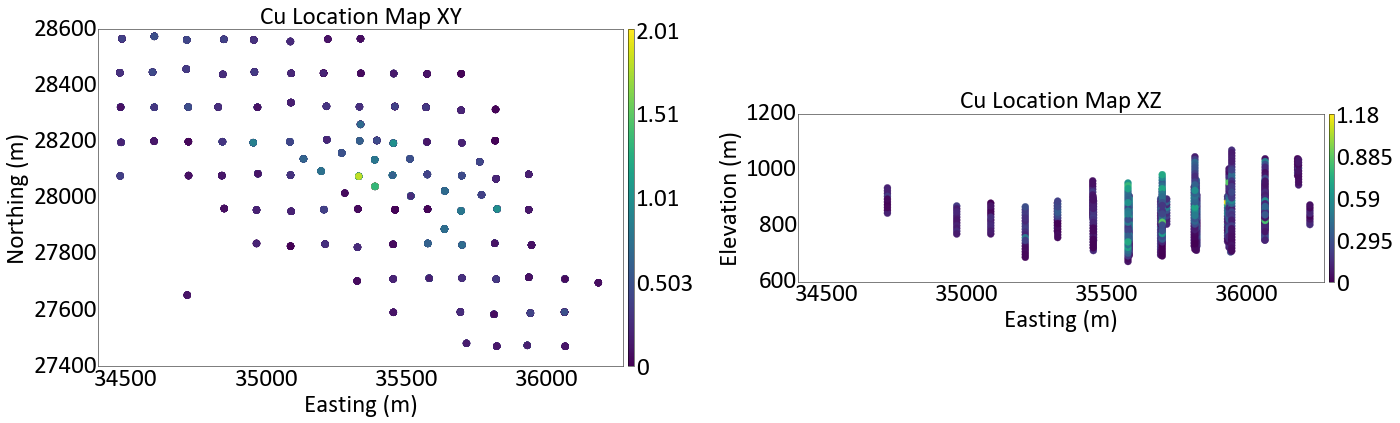

In [15]:
gs.set_style('pt25')
gridsize = (1,2)
fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot2grid(gridsize,(0,0)) 
ax2 = plt.subplot2grid(gridsize,(0,1))

gs.locmap(datafl,var = 'Cu',orient = 'xy',ax=ax1, title = 'Cu Location Map XY',slicetol=30)
gs.locmap(datafl,var = 'Cu',orient = 'xz',ax=ax2, title = 'Cu Location Map XZ',slicetol=30)
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/Locmap_{}.png'.format(plt_extent))

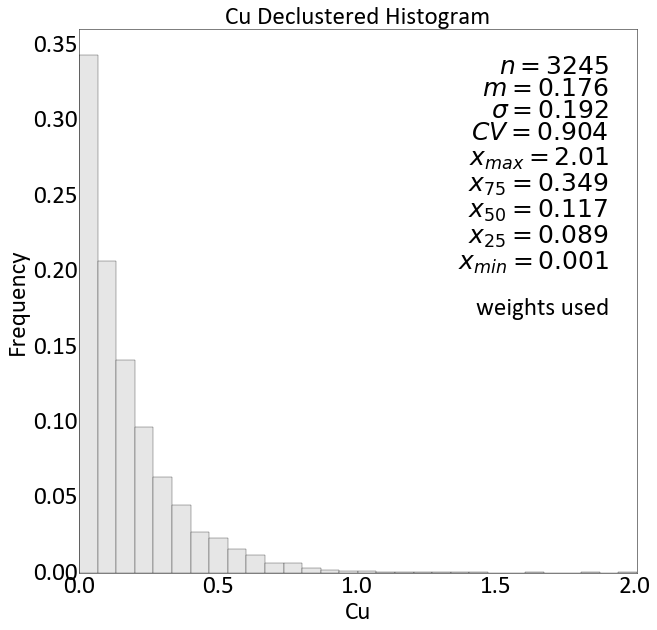

In [16]:
gs.histplt(declus_fl,var='Cu',wt='Declustering Weight',title = 'Cu Declustered Histogram',bins=30,xlim=(0,2.01),sigfigs=3,figsize = (10,10))
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/Histogram_{}.png'.format(plt_extent))

# Machine Learning

## Machine Learning Code

In [17]:
datatest = np.asarray(datafl.data)

close and current tensorflow sessions that are open

In [18]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
    tf.InteractiveSession.close(sess)
    sess.close()

setup plot settings

In [19]:
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

### K-Fold Validation

In [20]:
from sklearn.model_selection import KFold # import Sklearn kfold package
kf = KFold(n_splits = 5, shuffle=True) #  Specify the number of fuld and generally speaking we always want to shuffle the data

### Data Set up

In [21]:
#DH Sample Data
print('Here we will specify the data we wish to pass to the machine algorithm and extract the min and max values from the known data   in order to scale our the values we wish to predict to be between 0 and 1')
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])
print(min_val)
print(max_val)
datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)

Here we will specify the data we wish to pass to the machine algorithm and extract the min and max values from the known data   in order to scale our the values we wish to predict to be between 0 and 1
0.00075
2.0097099999999997


In [22]:
#Prediction Grid
x,y,z = griddef.gridcoord()
print('Generating the XYZ grid we wish to make a prediction on')
print(x,y,z)
data_x = np.hstack((x.reshape(len(x),1),y.reshape(len(y),1),z.reshape(len(z),1)))/100
print('the xyz values are then divide by 100 to help scale the data closer to the drill hole data values')
print(data_x)

Generating the XYZ grid we wish to make a prediction on
[34407.5 34422.5 34437.5 ... 36237.5 36252.5 36267.5] [27407.5 27407.5 27407.5 ... 28592.5 28592.5 28592.5] [ 607.5  607.5  607.5 ... 1192.5 1192.5 1192.5]
the xyz values are then divide by 100 to help scale the data closer to the drill hole data values
[[344.075 274.075   6.075]
 [344.225 274.075   6.075]
 [344.375 274.075   6.075]
 ...
 [362.375 285.925  11.925]
 [362.525 285.925  11.925]
 [362.675 285.925  11.925]]


In [23]:
n_batch = 20 
print('specify the number of sets to break the training data into')
print('Batch Training can help reduce overfitting by cycling through different groups of the training data for each trainin epoch')

specify the number of sets to break the training data into
Batch Training can help reduce overfitting by cycling through different groups of the training data for each trainin epoch


In [24]:
RFB_type = 'Gaussian'
print('Gaussian Kernels are currenlty the only kernel implmented')

Gaussian Kernels are currenlty the only kernel implmented


In [25]:
display_step = 50
print('The training and testint error will be calcualted ever {} training epochs along with a graph to track the progress'.format(display_step))

The training and testint error will be calcualted ever 50 training epochs along with a graph to track the progress


In [26]:
test_nodes = [10,15,20,30,50,75,100,125,150,175,200,225,250,275,300]
print('test_nodes can be set to a range of RBF nodes (eg.[10,20,30]) and the solution provided will be an esemble')
print('typically ensemble solutions are better then a single node solution')

test_nodes can be set to a range of RBF nodes (eg.[10,20,30]) and the solution provided will be an esemble
typically ensemble solutions are better then a single node solution


In [27]:
learning_rate = 0.01
training_epochs = 1500

print('typically a learning rate of 0.01 is reasonable; however, this is subject to change based on the problem')
print('trainig_epochs is proportional to the learning rate, the higher the learning reate the lower the number of epochs required; again the number of learning epochs can change based on the problem')


typically a learning rate of 0.01 is reasonable; however, this is subject to change based on the problem
trainig_epochs is proportional to the learning rate, the higher the learning reate the lower the number of epochs required; again the number of learning epochs can change based on the problem


# ERBFN

In [ ]:
columns = ['X','Y','Z','Cu']
fold_num= 0
kf.get_n_splits(datatest)
for train_index, test_index in kf.split(datatest):
    fold_num += 1
    print(fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    data_train, data_test = datatest[train_index,0:3]/100, datatest[test_index,0:3]/100
    target_train, target_test = datatest[train_index,3:4], datatest[test_index,3:4]
    gs.write_gslib(pd.DataFrame(np.hstack((data_train*100,target_train*(max_val-min_val)+min_val)),columns=columns), './data/data_train_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(np.hstack((data_test*100,target_test*(max_val-min_val)+min_val)),columns=columns), './data/data_test_{}.dat'.format(fold_num))
    row = 0
    NN = 'ERBFN' # RBFN or GRNN or 'EBFN'
    data_type = 'Continuous' # Continuous or Categorical
    test_nodes = test_nodes
    pred_all = np.zeros((len(test_nodes)*data_x.shape[0],target_train.shape[1]))
    pred_all_row = np.zeros((data_x.shape[0],target_train.shape[1],len(test_nodes)))
    info_matrix = np.zeros((len(test_nodes),8))
    for nodes in test_nodes:
        c_t = []
        c_test = []
        c_r2 = []
        epoch_plt = []
        start_time = time.time()
        print("Working on Node {} fold {} ".format(nodes,fold_num))
        k = nodes
        data_trainpd = pd.DataFrame(data_train)
        data = data_trainpd

        with tf.device('/device:CPU:0'):
            #clustering
            def input_fn():
              return tf.train.limit_epochs(
                  tf.convert_to_tensor(data_train, dtype=tf.float32), num_epochs=1)

            kmeans = tf.contrib.factorization.KMeansClustering(
                num_clusters=nodes, use_mini_batch=False)


            # train
            num_iterations = 10
            previous_centers = None
            for _ in range(num_iterations):
              kmeans.train(input_fn)
              cluster_centers = kmeans.cluster_centers()
              #if previous_centers is not None:
                #print('delta:', cluster_centers - previous_centers)
              previous_centers = cluster_centers
              #print('score:', kmeans.score(input_fn))
            #print('cluster centers:', cluster_centers)
            
             
        with tf.device(device):
            from tensorflow.python.framework import ops
            ops.reset_default_graph()


            RANDOM_SEED = 42
            tf.set_random_seed(RANDOM_SEED)

            N_INSTANCES = np.shape(data_train)[0]
            N_INPUT = data_train.shape[0]
            N_FEATURE = data_train.shape[1]
            N_CLASSES = target_train.shape[1]
            TRAIN_SIZE = int(N_INSTANCES)
            batch_size = int(np.shape(data_train)[0]/n_batch)
            training_epochs = training_epochs
            if nodes >= 2:
                training_epochs = 5000
            if nodes >= 2:
                training_epochs = 1500
            if nodes >= 25:
                training_epochs = 800
            if nodes >= 100:
                training_epochs = 500
            if nodes >= 1000:
                training_epochs = 250
            learning_rate = learning_rate
            epsilon = 0.001
            display_step = display_step
            hidden_size = nodes

            target_ = np.zeros((N_INSTANCES, N_CLASSES))
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            x_data = tf.placeholder(shape=[None, N_FEATURE], dtype=tf.float32, name = 'Features')
            y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32, name = 'Known_Values')


            dist = np.zeros((k,k))
            for i in range (0,k):
                for j in range (0,k):
                    dist[i:j] = distance.euclidean(cluster_centers[i], cluster_centers[j])
                    maxdist = dist.max()
            sigma = maxdist/np.sqrt(2*k)
            if nodes == 1 :
                beta = 0.2
            else:        
                beta = 1/math.pow(2*sigma,2)

            #EBFN
            if NN == 'EBFN':
                def rbf_network(input_layer, cluster_centers ,weights):
                    exp_list= []
                    f_prior_list = []
                    yy = weights['cluster_centers']

                    for i in range(nodes):

                        vv = weights['cov_mat'][:,:,i]
                        symA = 0.5 * tf.math.add(vv , tf.transpose(vv))
                        cc_i = yy[i]

                        diff = tf.subtract(input_layer, cc_i , name = 'subtract')

                        dt = tf.transpose(diff,name = 'Transpose')

                        M1 = tf.matmul(diff,symA,name = 'M1')

                        M2 = tf.matmul(M1,dt,name = 'M2')

                        sqrt = tf.math.sqrt(tf.math.abs(M2),name = 'sqrt')

                        diag = tf.linalg.tensor_diag_part(sqrt,name = 'diag') 

                        #gauss_f = tf_gaussian_function(diag ,name = 'gaussian_fxn_activation')

                        gauss_f = tf.math.exp((-tf.math.pow((weights['beta'][:,i]*diag), 2)))


    #                     gauss_f = tf.cast(gauss_f, tf.float64)

    #                     k = tf.math.add(gauss_f , 1e-4 * tf.eye(tf.shape(x_data)[0], dtype = tf.float64))

    #                     print(k)

    #                     dens = MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(k))

    #                     f_prior = dens.sample()

    #                     f_prior = gauss_f = tf.cast(f_prior, tf.float32)

                        exp_list.append(gauss_f)
                    layer2_act = tf.stack(exp_list)  
                    output = tf.add(tf.matmul(layer2_act, weights['output'],transpose_a=True,name = 'mult_layer2_by_weights'), 
                                    bias['output'], 
                                    name = 'add_bias_to_output')
                    return output


            weights = {
                'h1': tf.Variable(tf.ones([N_FEATURE, N_FEATURE]), name = 'layer1_dims',trainable = False),
                'h2': tf.Variable(tf.constant(value = 0.1, shape = [hidden_size, hidden_size]), name = 'layer1-2_Weights'),
                'output': tf.Variable(tf.random_normal([hidden_size, N_CLASSES], stddev=0.1), name = 'layer2_output_Weights'),
                'cov_mat': tf.Variable(tf.constant(1.0,shape = [N_FEATURE,N_FEATURE,nodes]), name = 'cov'),
                'beta' : tf.Variable(tf.constant(beta,shape = [1,nodes]) ,name = 'beta'),            
                'cluster_centers' : tf.Variable(tf.constant(np.asarray(cluster_centers).reshape(nodes,N_FEATURE),
                                    shape = [nodes,N_FEATURE]), name = 'cluster_center')
            }

            bias = {
                'output' : tf.Variable([0],name='output_bias',dtype=tf.float32)  
            }


            pred = rbf_network(x_data, cluster_centers ,weights)

            if data_type == 'Continuous':
                with tf.name_scope('cost'):
                    cost = tf.reduce_mean(tf.square(pred - y_target))
                    #cost = tf.math.reduce_sum(tf.square(pred - y_target)) 
                    my_opt = tf.train.AdamOptimizer(learning_rate,beta1=0.5).minimize(cost)  
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    total_error = tf.reduce_sum(tf.square(tf.subtract(y_target, tf.reduce_mean(y_target))))
                    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_target, pred)))
                    accuracy = tf.subtract(1.00, tf.divide(unexplained_error, total_error))

            if data_type == 'Categorical':
                with tf.name_scope('cost'):
                    if N_CLASSES == 1:
                        cost = tf.reduce_mean(tf.square(tf.round(pred) - y_target)) 
                    else:
                        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = pred))
                    my_opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    correct_prediction = tf.equal(tf.round(pred), y_target)
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#             tf.summary.histogram("cov_mat", weights['cov_mat'])
#             tf.summary.histogram("Weights_Output_Layer", weights['output'])
#             tf.summary.histogram("Bias_Output_Layer", bias['output'])




            init = tf.global_variables_initializer()
            sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
            merged = tf.summary.merge_all()
            saver = tf.train.Saver()
            writer = tf.summary.FileWriter('./test',sess.graph)
            sess.run(init)
            tol = 0.00001
            epoch, err, acc=0, 1, 0
            # Training loop
            #saver.restore(sess,'./spatial/test_dataset_{}.ckpt'.format(nodes))
            while epoch <= training_epochs and err >= tol and acc <= 0.63:

                avg_cost = 0.
                acc = 0.
                total_batch = int(data_train.shape[0] / batch_size)
                for i in range(total_batch):
                    randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
                    batch_xs = data_train[randidx , :]
                    batch_ys = target_train[randidx , :]
                    sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
                    avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                    acc += sess.run(accuracy, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                err = avg_cost
                if epoch % 100 == 0:
                    epoch_plt.append(epoch)
#                     w = np.vsplit(data_x,500)[0].shape[0]
#                     pred1 = np.zeros((data_x.shape[0],N_CLASSES))
#                     for i in range(0,500):
#                         pred1[i*w:(1+i)*w,0:N_CLASSES] = (sess.run(pred, feed_dict={x_data:np.vsplit(data_x,500)[i]}))*(max_val-min_val)+min_val
#                     gs.pixelplt(pd.DataFrame(pred1),griddef=griddef,figsize=(20,20) ,title = 'Training Step {}'.format(epoch),sliceno=18)
                    clear_output(wait=True)
                    #summary = sess.run([merged],feed_dict={x_data: batch_xs, y_target: batch_ys})
                    #writer.add_summary(summary,epoch)
                    print("Epoch: {}/{} err = {}".format(epoch, training_epochs, avg_cost))
                    print('Cost_test :',sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_t.append(avg_cost)
                    c_test.append(sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_r2.append(acc)
                    if data_type == 'Categorical': 
                        print("Accuracy:{}".format(acc))
                    else:
                        print("R^2:{}".format(acc))    
                    SMALL_SIZE = 15
                    plt.rc('font', size=SMALL_SIZE)
                    plt.rc('axes', titlesize=SMALL_SIZE)
                    f, (ax1) = plt.subplots(1, 1,figsize=(16, 8))
                    ax1.set_xlim(0, 5000)
                    ax1.set_ylim([0,15])
                    ax1.plot(np.asarray(epoch_plt), np.asarray(c_t)*100, label ='Training Cost')
                    ax1.plot(np.asarray(epoch_plt), np.asarray(c_test)*100, color="red",label ='Test Cost')
                    ax1.set_xlabel('Training Step')
                    ax1.grid(True)
                    ax1.set_title('Cost of Training/Testing Vs R2 Value Training Step {} Number'.format(epoch))
                    ax1.set_ylabel('Cost Of Trainin in % Error', color='blue')
                    ax1.tick_params(axis='y', labelcolor='blue')
                    ax2 = ax1.twinx()
                    ax2.plot(np.asarray(epoch_plt), c_r2,'-',color="orange",label ='R2 Value')
                    ax2.set_ylim([-1,1])
                    ax2.set_ylabel('R2 Value', color='orange')
                    ax2.tick_params(axis='y', labelcolor='orange')
                    lines, labels = ax1.get_legend_handles_labels()
                    lines2, labels2 = ax2.get_legend_handles_labels()
                    ax2.legend(lines + lines2, labels + labels2, loc=3)
                    plt.show()
                epoch +=1
                

            print ("End of learning process")
            print ("Final epoch = {}/{} ".format(epoch, training_epochs))
            print ("Final error = {}".format(err) )
            print ("Final R^2 = {}".format(acc) )
            saver.save(sess,'./spatial/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            w = np.vsplit(data_x,500)[0].shape[0]
            pred1 = np.zeros((data_x.shape[0],N_CLASSES))
            for i in range(0,500):
                pred1[i*w:(1+i)*w,0:N_CLASSES] = (sess.run(pred, feed_dict={x_data:np.vsplit(data_x,500)[i]}))*(max_val-min_val)+min_val
                pred_all[i*w+(row*data_x.shape[0]):(1+i)*w+(row*data_x.shape[0]),0:N_CLASSES] = pred1[i*w:(1+i)*w,0:N_CLASSES]
                pred_all_row[i*w:(1+i)*w,0:N_CLASSES,row] = pred1[i*w:(1+i)*w,0:N_CLASSES]
                    

            writer = tf.summary.FileWriter("sess_graph", sess.graph)
            saver.save(sess,'test/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            sess.close() 

            gs.write_gslib(pd.DataFrame(pred1), './predictions/real_{}_{}.dat'.format(nodes,fold_num))

            row +=1
            tf.InteractiveSession.close(sess)


    ensemble = numpy.nanmean(pred_all_row, axis = 2)
    gs.write_gslib(pd.DataFrame(ensemble), './predictions/ensemble_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(pred_all), './predictions/all_real_{}.dat'.format(fold_num))


In [28]:
datafl = gs.DataFile(flname='largedata.dat', griddef = griddef,
                       readfl=True)

In [29]:
data_xyz = datafl[['X','Y','Z']].values
data_xyz

array([[36226.   , 27295.1  ,   803.75 ],
       [36226.   , 27295.1  ,   813.75 ],
       [36226.   , 27295.1  ,   823.75 ],
       ...,
       [34354.6  , 28200.3  ,   841.225],
       [34354.6  , 28200.3  ,   851.225],
       [34354.6  , 28200.3  ,   861.225]])

In [57]:
grid_xyz = np.zeros((len(x),3))
for i in range(len(x)):
    grid_xyz[i,0] = x[i]
    grid_xyz[i,1] = y[i]
    grid_xyz[i,2] = z[i]

In [58]:
tree = scs.KDTree(data_xyz)

In [59]:
key = []
for i in range(len(grid_xyz)):
    distance, index = tree.query(grid_xyz[i],k=1)
    if distance <= 250:
        key.append(1)
    else:
        key.append(0)

In [60]:
np.sum(key)

333793

In [61]:
gs.write_gslib(pd.DataFrame(key,columns=['Keyout']),'key_out.out')

In [62]:
key_out = gs.DataFile('Key_out.out',griddef=griddef)

In [73]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21          -  trimming limits
declus/declus_{fold}.sum                  -file for summary output
declus/declus_{fold}.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  25  250.0               -number of cell sizes, min size, max size
100                           -number of origin offsets
"""
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
100 15 1000 -10.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 7  100.0  75.0                  -        number of lags,lag distance,lag tolerance
190 15 1000 -10.0 22.5 1000 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 7  100.0  75.0                  -        number of lags,lag distance,lag tolerance
0. 5 1000 -90.0 5 1000 0.0     -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 20  10   5                 -        number of lags,lag distance,lag tolerance
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1          200                       -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  100.0 -10.0  1000   0.5      -  azm, dip, npoints, point separation
  190 -10.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.0:0.01              -  nst, nugget effect
1    0.35   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       45    45    30       - a_hmax, a_hmin, a_vert
1    0.64   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       380    340    340       - a_hmax, a_hmin, a_vert
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
5    5      5                    -x,y and z block discretization
8    100    12    1               -min, max data for kriging,upper max for ASO,ASO incr
90      0                         -max per octant, max per drillhole (0-> not used)
1000.0  1000.0  1000.0              -maximum search radii
100.0   0   0.0                 -angles for search ellipsoid
0                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.180 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
key_out.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
2    0.01              -  nst, nugget effect
1    0.350000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       45    45    30       - a_hmax, a_hmin, a_vert
1    0.640000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       380    340    340       - a_hmax, a_hmin, a_vert
"""

In [74]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
declus = gs.Program('declus') 
for fold in range(1,5):
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold),griddef=griddef)

    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('Cu'),
                         fold = fold))
    
    declus_mean = np.min(np.asarray(gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Declustered Mean'][gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))

    
    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Cu'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Cu'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold,
                             mean = declus_mean))

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_1.dat                 
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = declus/declus_1.sum                     
 output file = declus/declus_1.out                     
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =          100       25.000000      250.000000
 offsets =          100


There are     2491 data with:
  mean value            =      0.22035
  minimum and maximum   =      0.00075     1.82000
  size of data vol in X =   1957.80078
  size of data vol in Y =   1352.30078
  size of data vol in Z =    663.14954

  declustered mean      =      0.19953
  min and max weight    =      0.37453     4.89581
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.
Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_tr

   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on estimate    380000
   currently on estimate    390000
   currently on estimate    400000

 KT3DN Version:    7.4.7 Finished

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_2.dat                 
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = declus/declus_2.sum                     
 output file = declus/declus_2.out                     
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =          100       25.000000      250.000000
 offsets =          100


There are     2491 data with:
  mean value            =      0.25291
  minimum and maximum   =      0.00075     2.00971
  size of data vol in X =   1998.19922
  size of data vol in Y =   1711.19922
  size of data vol in Z =    600

   currently on estimate    260000
   currently on estimate    270000
   currently on estimate    280000
   currently on estimate    290000
   currently on estimate    300000
   currently on estimate    310000
   currently on estimate    320000
   currently on estimate    330000
   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on estimate    380000
   currently on estimate    390000
   currently on estimate    400000

 KT3DN Version:    7.4.7 Finished

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_3.dat                 
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = declus/declus_3.sum                     
 output file = declus/declus_3.out                     
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =          100       25

   currently on estimate    180000
   currently on estimate    190000
   currently on estimate    200000
   currently on estimate    210000
   currently on estimate    220000
   currently on estimate    230000
   currently on estimate    240000
   currently on estimate    250000
   currently on estimate    260000
   currently on estimate    270000
   currently on estimate    280000
   currently on estimate    290000
   currently on estimate    300000
   currently on estimate    310000
   currently on estimate    320000
   currently on estimate    330000
   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on estimate    380000
   currently on estimate    390000
   currently on estimate    400000

 KT3DN Version:    7.4.7 Finished

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_4.dat                 
 columns =            1           2           3     

   currently on estimate    100000
   currently on estimate    110000
   currently on estimate    120000
   currently on estimate    130000
   currently on estimate    140000
   currently on estimate    150000
   currently on estimate    160000
   currently on estimate    170000
   currently on estimate    180000
   currently on estimate    190000
   currently on estimate    200000
   currently on estimate    210000
   currently on estimate    220000
   currently on estimate    230000
   currently on estimate    240000
   currently on estimate    250000
   currently on estimate    260000
   currently on estimate    270000
   currently on estimate    280000
   currently on estimate    290000
   currently on estimate    300000
   currently on estimate    310000
   currently on estimate    320000
   currently on estimate    330000
   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on esti

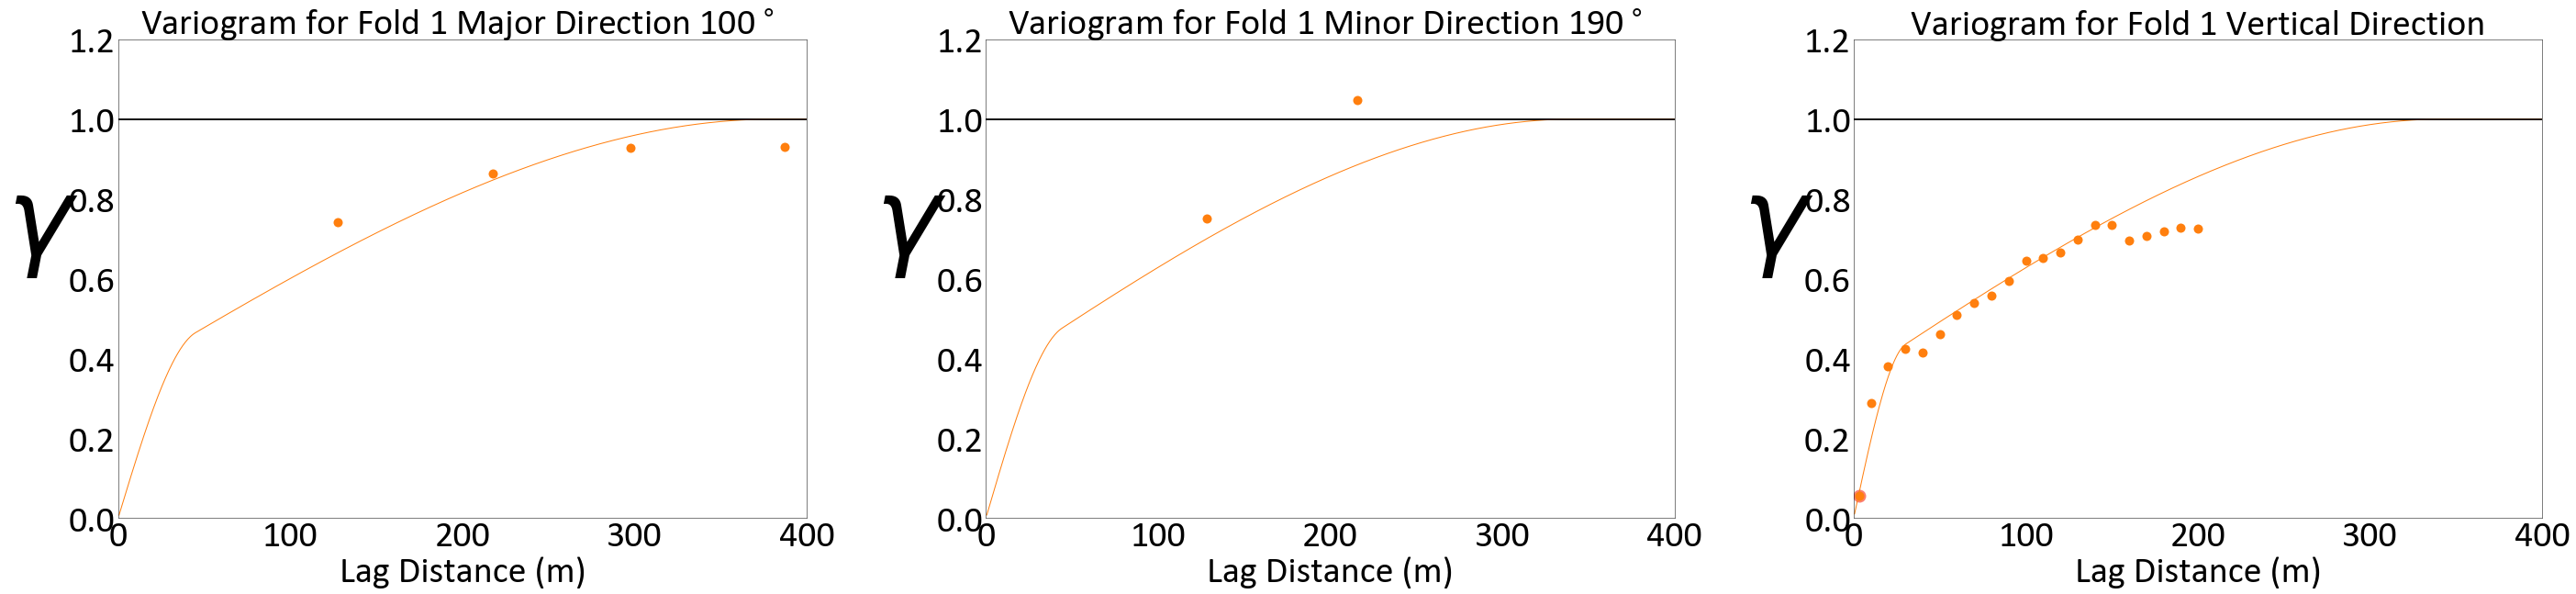

In [30]:
gs.set_style('pt40')
xlim = (0,400)
ylim = (0,1.2)
for fold in range(1,2):
    f, (ax,ax2,ax3) = plt.subplots(1, 3, figsize=(40, 10))
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    
    
    ax1 = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Variogram for Fold {} Major Direction 100$^\circ$ '.format(fold),label= 'Experimental',xlim=xlim)
    ax1 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Variogram for Fold {} Major Direction 100$^\circ$ '.format(fold),label= 'Model',xlim=xlim)

    ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Variogram for Fold {} Minor Direction 190$^\circ$ '.format(fold),label= 'Experimental',xlim=xlim)
    ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Variogram for Fold {} Minor Direction 190$^\circ$ '.format(fold),label= 'Model',xlim=xlim)

    ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10, title = 'Variogram for Fold {} Vertical Direction'.format(fold),label= 'Experimental',xlim=xlim)
    ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 3,ax =ax3, title = 'Variogram for Fold {} Vertical Direction'.format(fold),label= 'Model',xlim=xlim)

    plt.tight_layout()    
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/vargs_{}.png'.format(plt_extent))
    plt.show()


In [31]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

In [168]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21          -  trimming limits
declus.sum                  -file for summary output
declus.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
99  100.0  250.0               -number of cell sizes, min size, max size
100                           -number of origin offsets
"""

varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
100 15 1000 -10.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 7  100.0  75.0                  -        number of lags,lag distance,lag tolerance
190 15 1000 -10.0 22.5 1000 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 7  100.0  75.0                  -        number of lags,lag distance,lag tolerance
0. 5 1000 -90.0 5 1000 0.0     -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 20  10   5                 -        number of lags,lag distance,lag tolerance
./vargs/varcalc_OICCK_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  135.0 -10.0  1000   0.5      -  azm, dip, npoints, point separation
   45.0 -10.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.0:0.01              -  nst, nugget effect
1    0.400000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       45    45    30       - a_hmax, a_hmin, a_vert
1    0.600000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       380    340    340       - a_hmax, a_hmin, a_vert
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1   2000000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_OICCK_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}              -file with data
0  {xyzcol}  {varcol}  {seisnscol}                 -  columns for DH,X,Y,Z,var,sec var
-99    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./ML+ICCK/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
10    100    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
1000  1000  1000              -maximum search radii
100.0  0   0.0                 -angles for search ellipsoid
7                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0  {corr}  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
{seisfl}                     -gridded file with drift/mean
{seiscol}                                -  column number in gridded file
key_out.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
2    0.01              -  nst, nugget effect
1    0.350000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       45    45    30       - a_hmax, a_hmin, a_vert
1    0.640000000   100.0   -10.0   0.0   - it,cc,ang1,ang2,ang3
       380    340    340       - a_hmax, a_hmin, a_vert
"""

In [75]:
griddef2 = gs.GridDef(gridfl='griddef2.txt')
griddef2

Pygeostat GridDef:
125 34407.51 15.0 
80 27407.5 15.0 
40 607.5 15.0

In [170]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
declus = gs.Program('declus')   


for fold in range(1,5):
    
    sesi_data = gs.DataFile('predictions\ensemble_{}.dat'.format(fold))
    
    sesi_data = gaussian_filter((sesi_data.data['0']),sigma = 8)
    
    gs.write_gslib(pd.DataFrame(sesi_data),'predictions\smooth_ensemble_{}.dat'.format(fold))
    
    sesi_data = gs.DataFile('predictions\smooth_ensemble_{}.dat'.format(fold))
    
    Testdat = gs.DataFile('declus/declus_{}.out'.format(fold),griddef=griddef)
    
    idx,ingrid = griddef.coord_to_index1d(x=Testdat.data['X'],y=Testdat.data['Y'],z=Testdat.data['Z'])
    
    Testdat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Testdat,'./data/data_test_NS_{}.dat'.format(fold))
    
    Testdat = gs.DataFile('./data/data_test_NS_{}.dat'.format(fold))   
    
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))
    
    idx,ingrid = griddef.coord_to_index1d(x=Traindat.data['X'],y=Traindat.data['Y'],z=Traindat.data['Z']) 
    
    Traindat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Traindat,'./data/data_train_NS_{}.dat'.format(fold))
    
    Traindat = gs.DataFile('./data/data_train_NS_{}.dat'.format(fold))
    
    declus.run(declusstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Cu')))
    
    Traindat = gs.DataFile('declus.out',griddef=griddef)  
        
    for i in range(len(Traindat['Cu'])):
        if Traindat['sesi_data'].isna()[i] == True:
            Traindat['sesi_data'][i] = Traindat['Cu'][i]
            
    gs.write_gslib(Traindat,'./nscore/runfl_{}.out'.format(fold))      

    Traindat = gs.DataFile('nscore/runfl_{}.out'.format(fold),griddef=griddef)
    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Cu'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))


    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open('./vargs/varmodel_OICCK_{}.var'.format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    

    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                                 seisfl = sesi_data.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Cu'),
                             seiscol = sesi_data.gscol('0'),
                             griddef = griddef2,
                             varg = varg,
                             seisnscol = Traindat.gscol('sesi_data'),
                             corr = np.corrcoef(Traindat.data.dropna()['Cu'],Traindat.data.dropna()['sesi_data'])[0,1],
                             fold = fold))
    
    print(np.corrcoef(Traindat.data.dropna()['Cu'],Traindat.data.dropna()['sesi_data'])[0,1])
    
    kt3dnfl = gs.DataFile('./ML+ICCK/kt3dn_{}.out'.format(fold))
    
    dh_dat = gs.DataFile('./data/data_train_{}.dat'.format(fold))  
    
    gs.write_gslib(kt3dnfl,'./backtr/backtr_UDDH_{}.out'.format(fold))
    

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_NS_1.dat              
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = declus.sum                              
 output file = declus.out                              
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =           99      100.000000      250.000000
 offsets =          100


There are     2491 data with:
  mean value            =      0.22035
  minimum and maximum   =      0.00075     1.82000
  size of data vol in X =   1957.80078
  size of data vol in Y =   1352.30078
  size of data vol in Z =    663.14954

  declustered mean      =      0.19956
  min and max weight    =      0.36628     4.92496
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.
Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: nscore/runfl_1

   currently on estimate    290000
   currently on estimate    300000
   currently on estimate    310000
   currently on estimate    320000
   currently on estimate    330000
   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on estimate    380000
   currently on estimate    390000
   currently on estimate    400000

 KT3DN Version:    7.4.7 Finished

0.7258313746956194
Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_NS_2.dat              
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = declus.sum                              
 output file = declus.out                              
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =           99      100.000000      250.000000
 offsets =          100


There are     2491 data with:
  mean

   currently on estimate    150000
   currently on estimate    160000
   currently on estimate    170000
   currently on estimate    180000
   currently on estimate    190000
   currently on estimate    200000
   currently on estimate    210000
   currently on estimate    220000
   currently on estimate    230000
   currently on estimate    240000
   currently on estimate    250000
   currently on estimate    260000
   currently on estimate    270000
   currently on estimate    280000
   currently on estimate    290000
   currently on estimate    300000
   currently on estimate    310000
   currently on estimate    320000
   currently on estimate    330000
   currently on estimate    340000
   currently on estimate    350000
   currently on estimate    360000
   currently on estimate    370000
   currently on estimate    380000
   currently on estimate    390000
   currently on estimate    400000

 KT3DN Version:    7.4.7 Finished

0.742200606672272
Calling:  ['declus', 'temp']

DECLUS

   currently on estimate     10000
   currently on estimate     20000
   currently on estimate     30000
   currently on estimate     40000
   currently on estimate     50000
   currently on estimate     60000
   currently on estimate     70000
   currently on estimate     80000
   currently on estimate     90000
   currently on estimate    100000
   currently on estimate    110000
   currently on estimate    120000
   currently on estimate    130000
   currently on estimate    140000
   currently on estimate    150000
   currently on estimate    160000
   currently on estimate    170000
   currently on estimate    180000
   currently on estimate    190000
   currently on estimate    200000
   currently on estimate    210000
   currently on estimate    220000
   currently on estimate    230000
   currently on estimate    240000
   currently on estimate    250000
   currently on estimate    260000
   currently on estimate    270000
   currently on estimate    280000
   currently on esti

 Presorting the data along an arbitrary vector
 Data was presorted with angles:   12.5000000000000        12.5000000000000     
   12.5000000000000     
 Setting up rotation matrices for variogram and search
 Setting up super block search strategy
 
 Working on the kriging 
   currently on estimate     10000
   currently on estimate     20000
   currently on estimate     30000
   currently on estimate     40000
   currently on estimate     50000
   currently on estimate     60000
   currently on estimate     70000
   currently on estimate     80000
   currently on estimate     90000
   currently on estimate    100000
   currently on estimate    110000
   currently on estimate    120000
   currently on estimate    130000
   currently on estimate    140000
   currently on estimate    150000
   currently on estimate    160000
   currently on estimate    170000
   currently on estimate    180000
   currently on estimate    190000
   currently on estimate    200000
   currently on estimate 

# Model Checking

In [76]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

So now that we have made our k-fold estimation we need to validate the models:
\begin{enumerate}
	\item check the $R^2$ of the model
    \item Ensure there is no artifacts in the estimation
    \item check the RMSE error and correlation in the Scatter plots, the correlation in training scatter plot should be similar to the correlation in the testing scatter plot
    \item check histogram and mean reproduction    
\end{enumerate}

\begin{equation}
    R^2 = 1 - \frac{\sum(z_i-z_i^*)^2}{\sum(z_i-\overline{z})^2}
    \label{eq:R-Squared Equation}
\end{equation}

## Model Checking Code

The model checking results below all fold look good except fold 9; this could easily be corrected by changing the number number of training step (adding a few hundred steps).

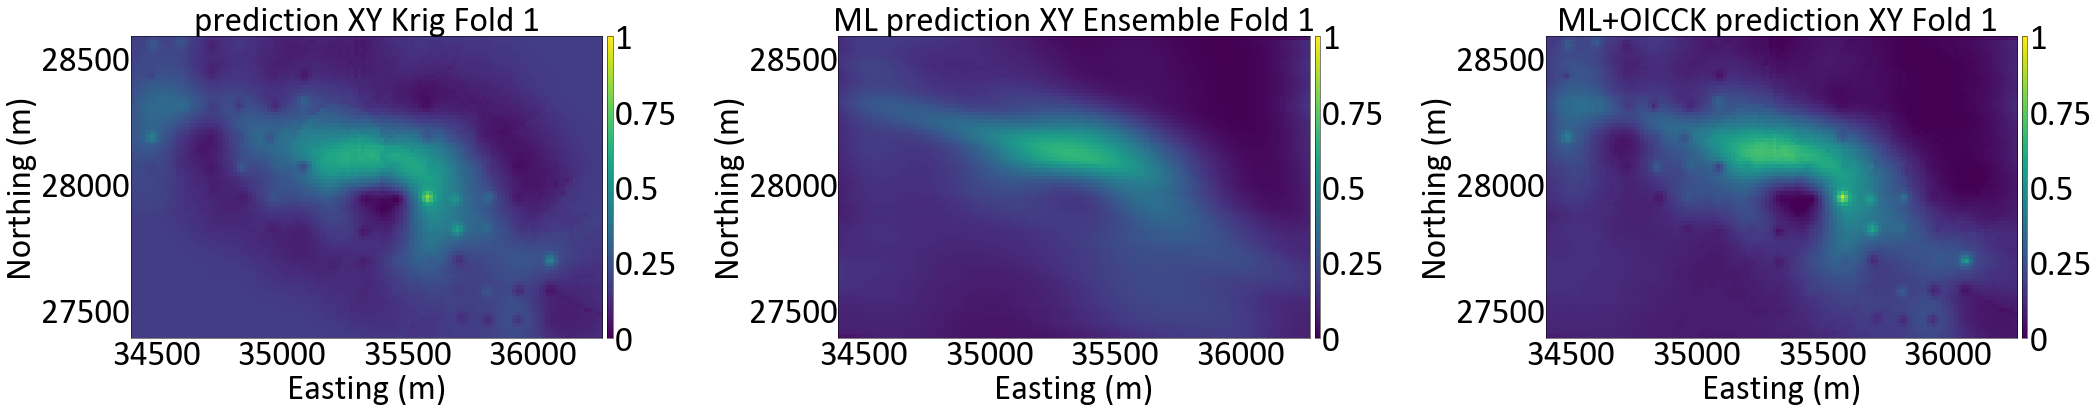

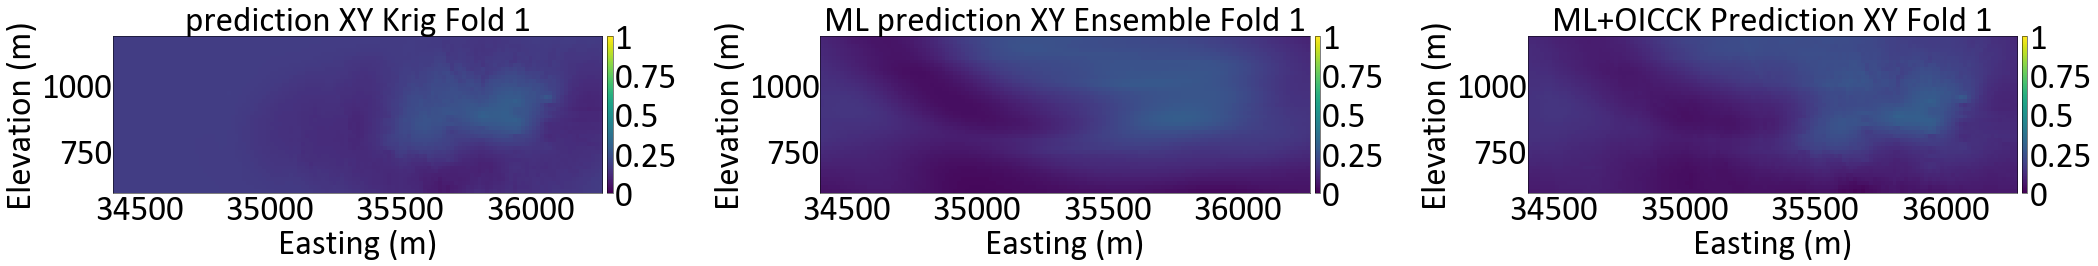

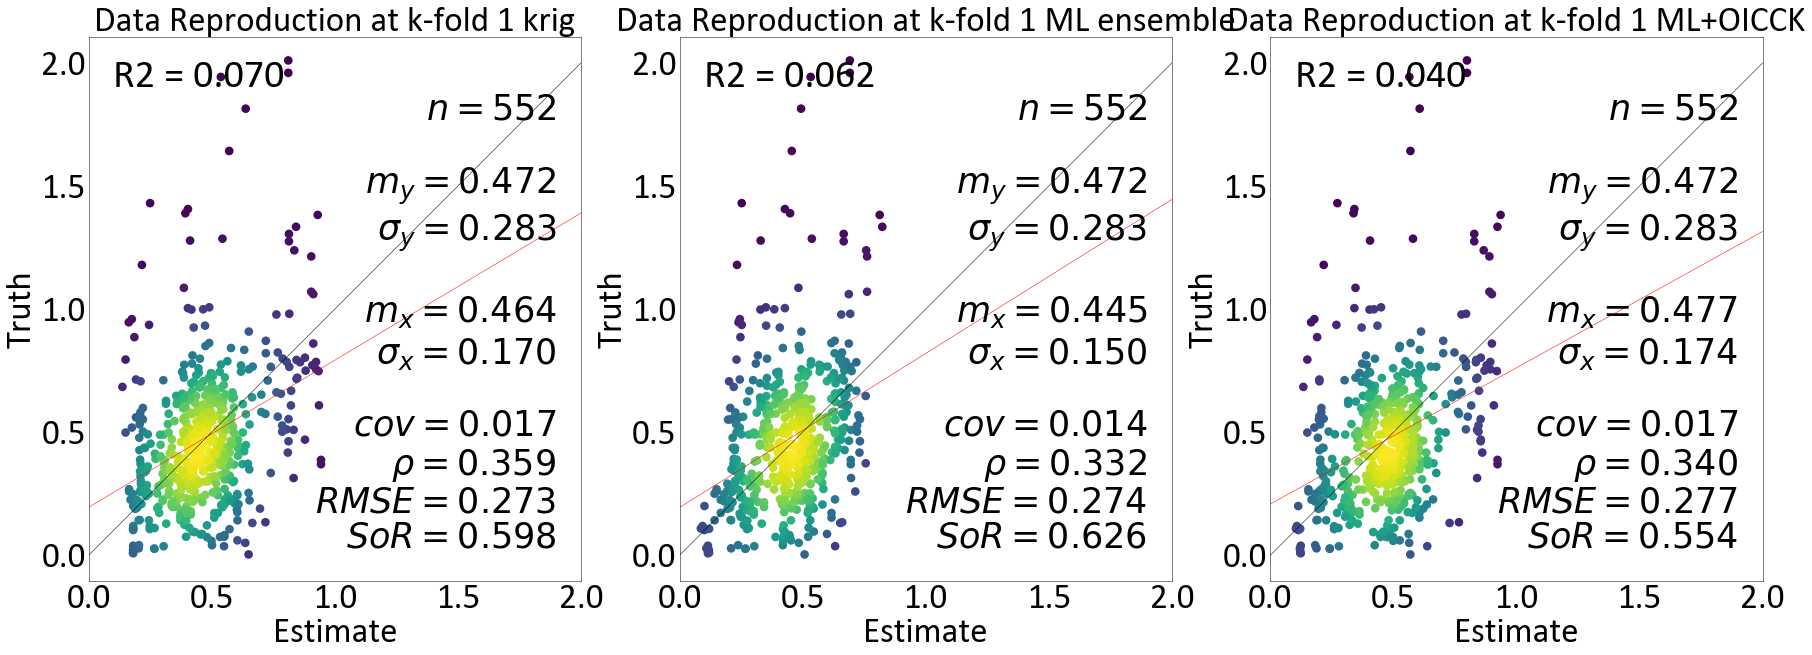

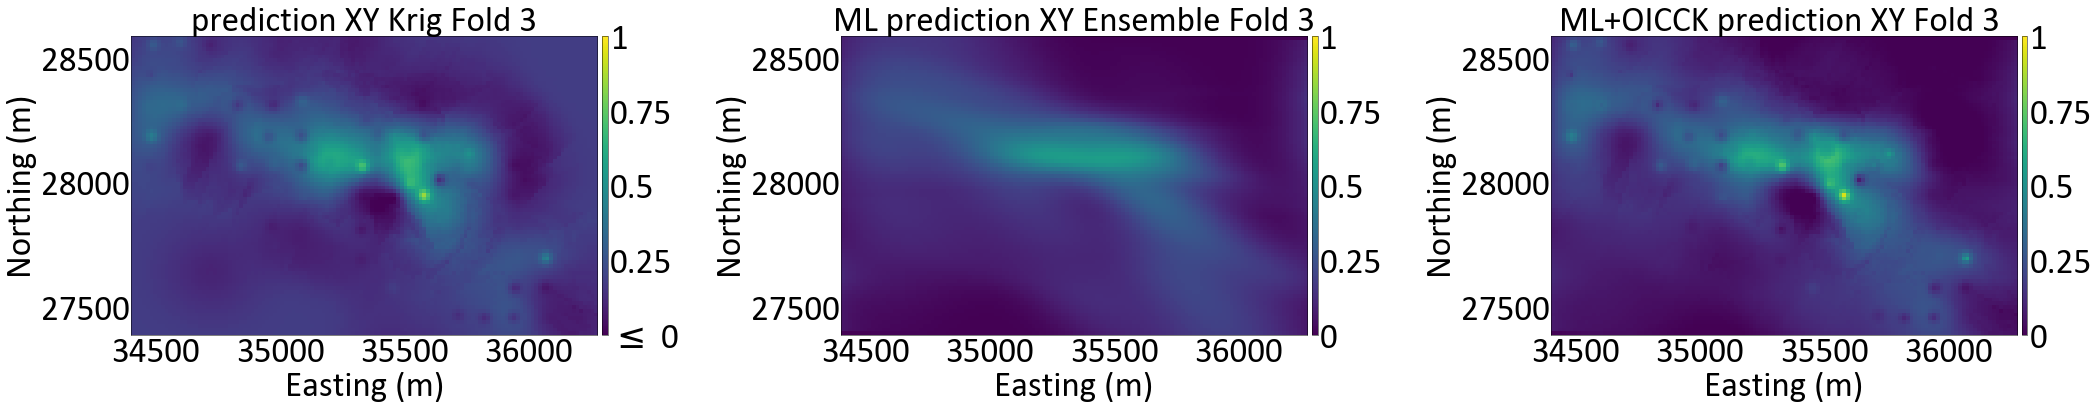

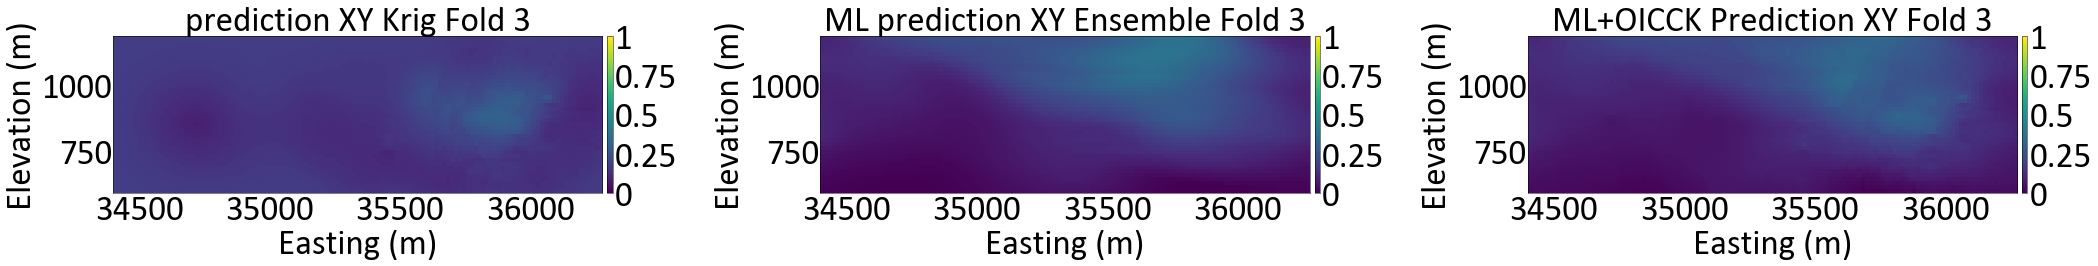

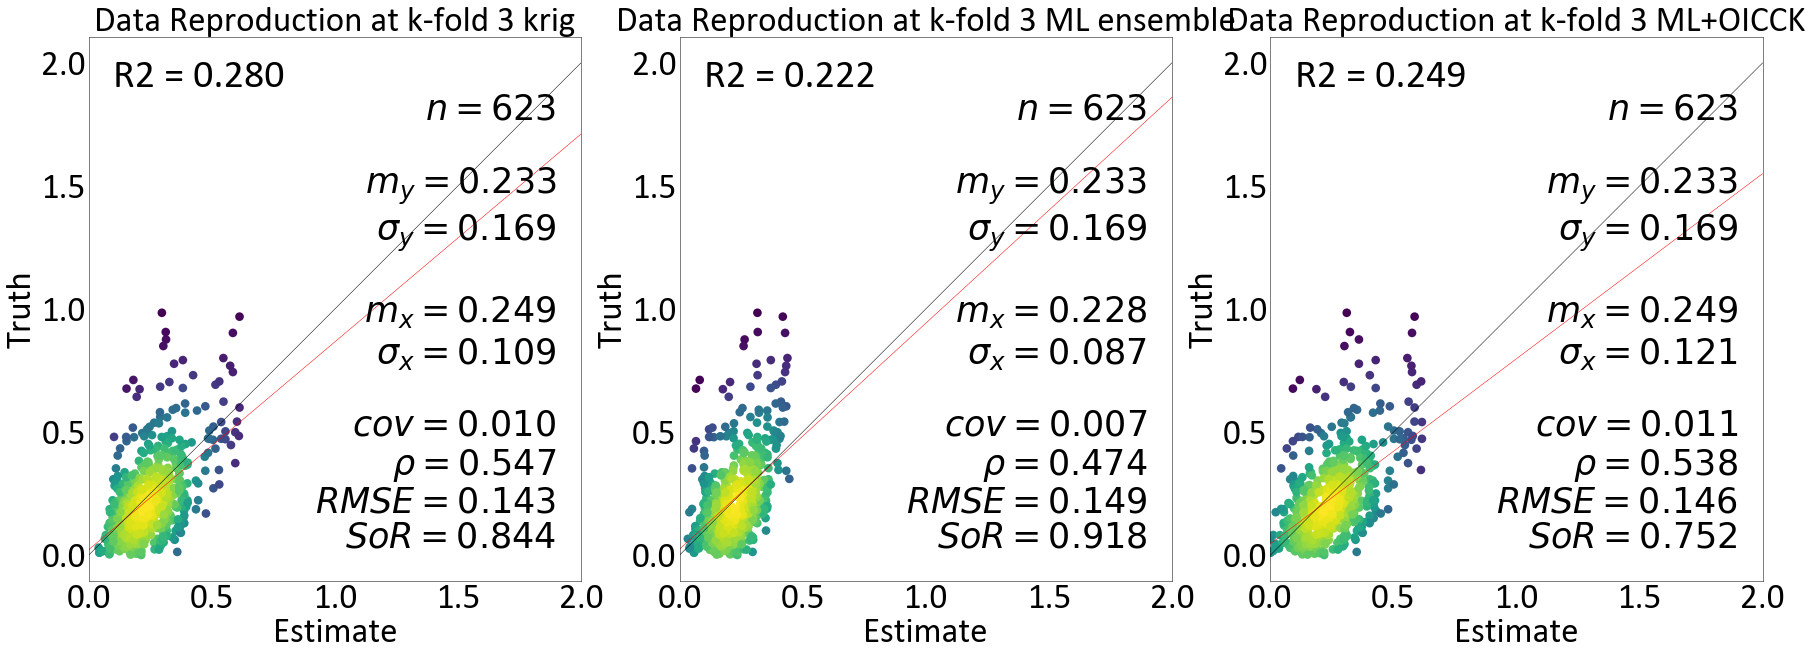

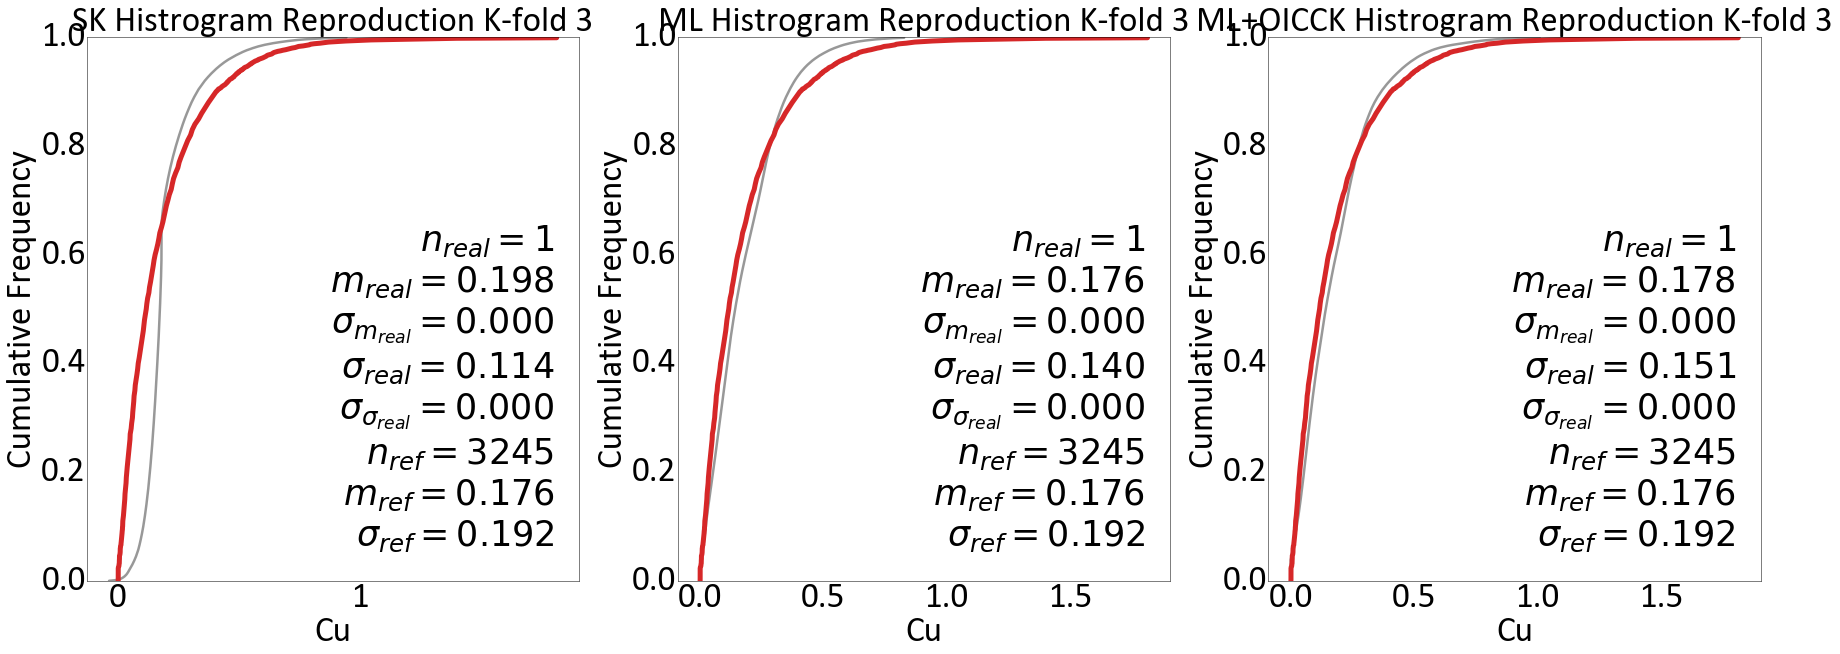

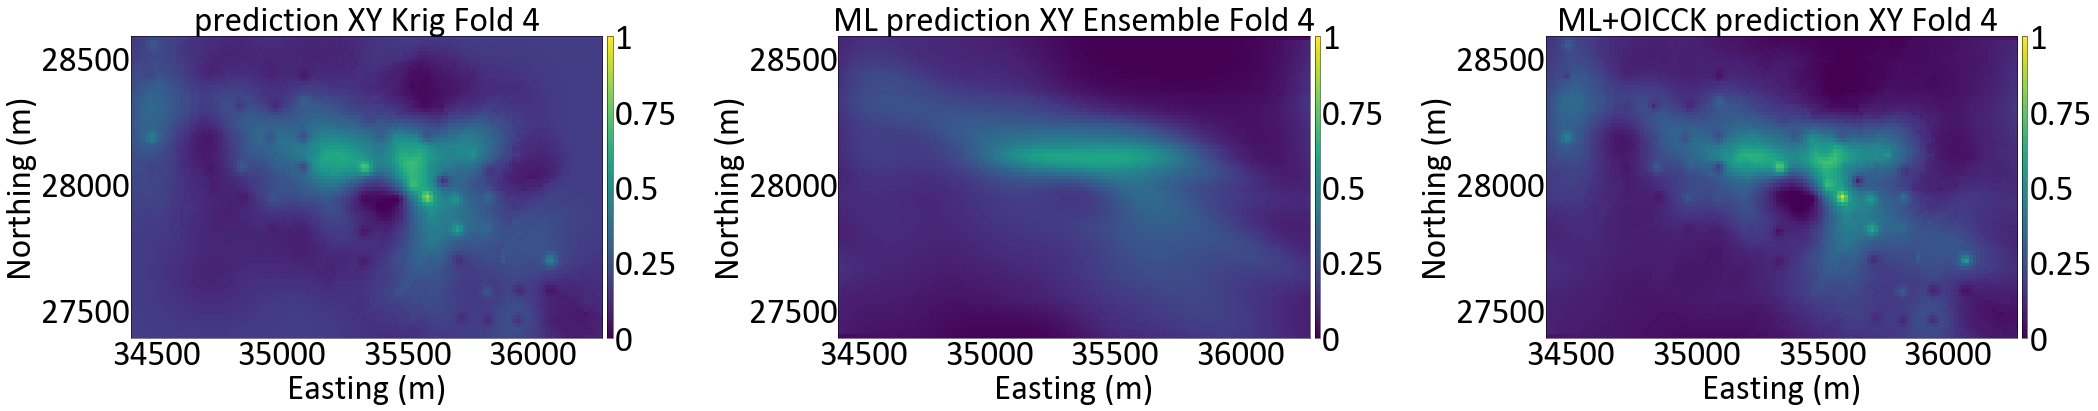

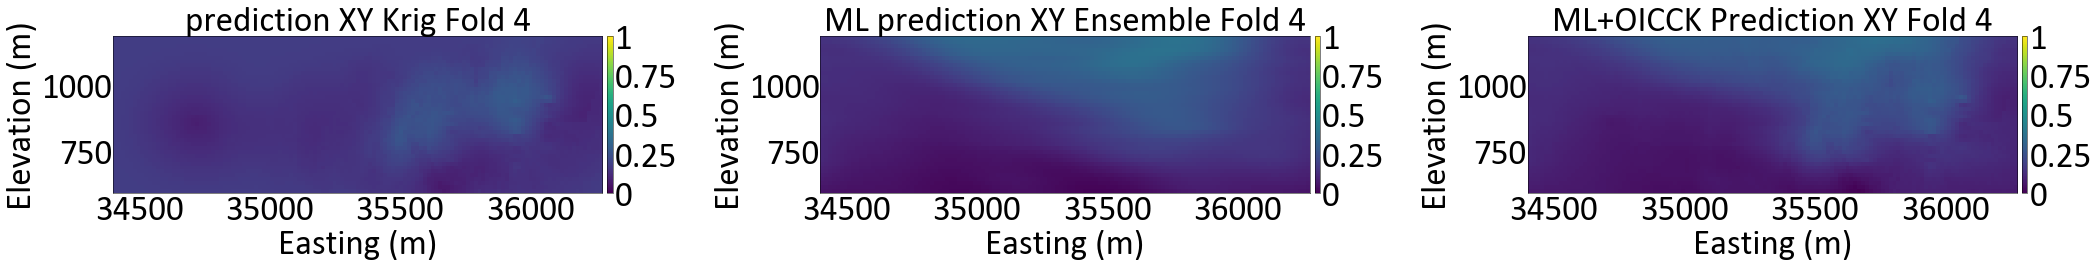

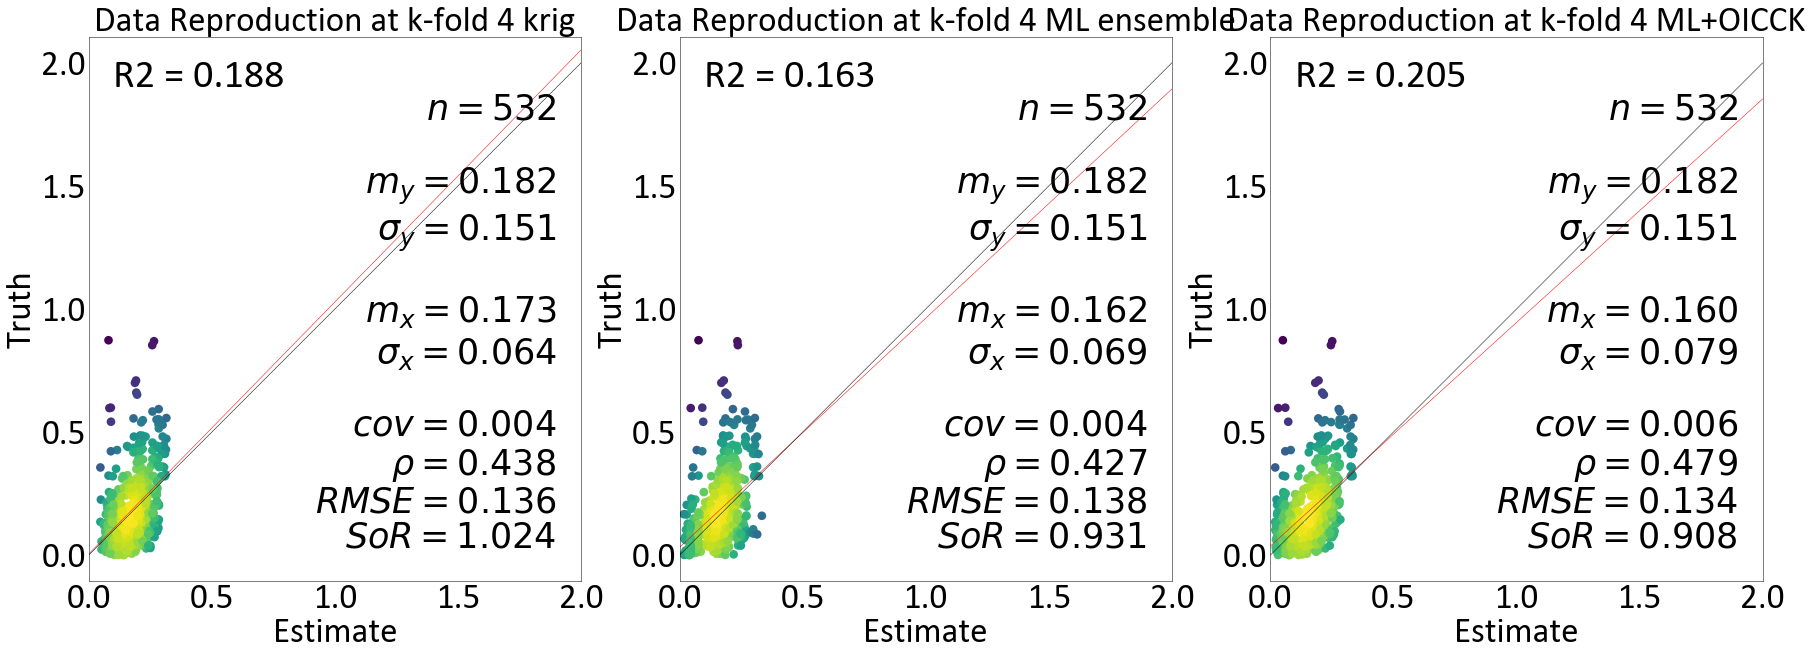

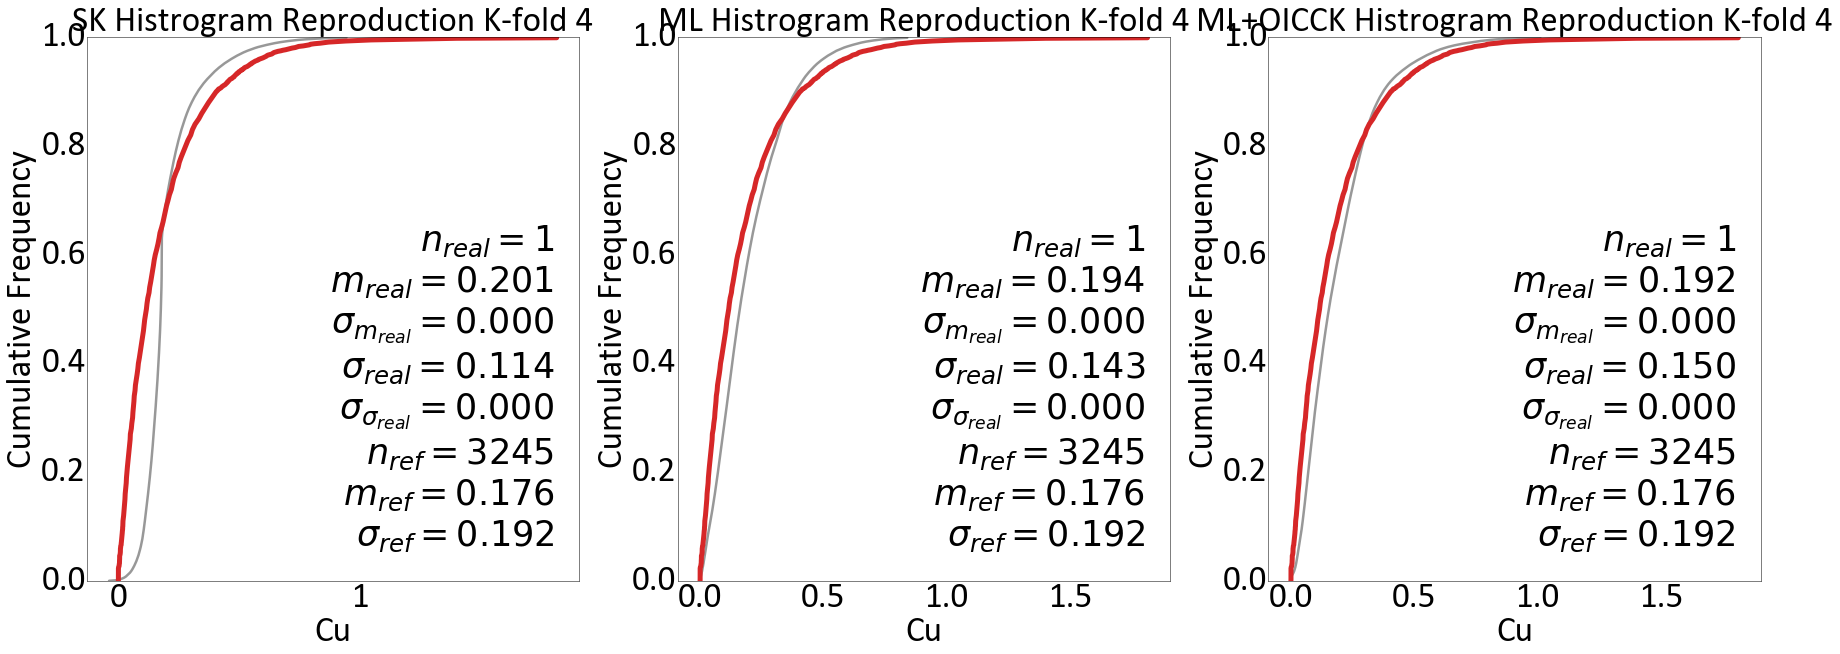

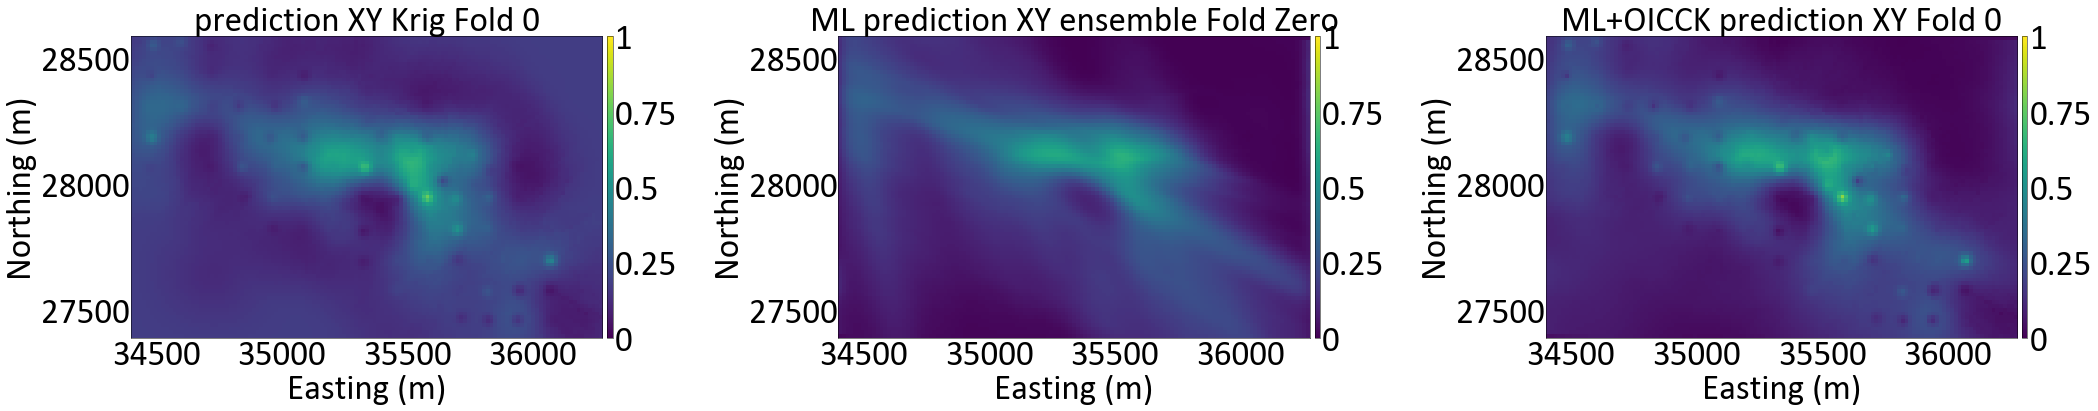

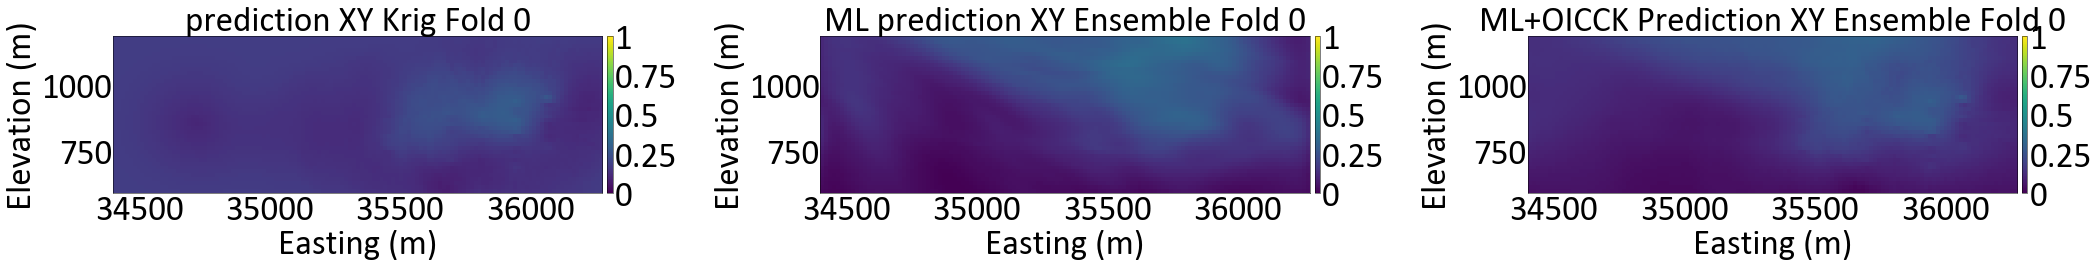

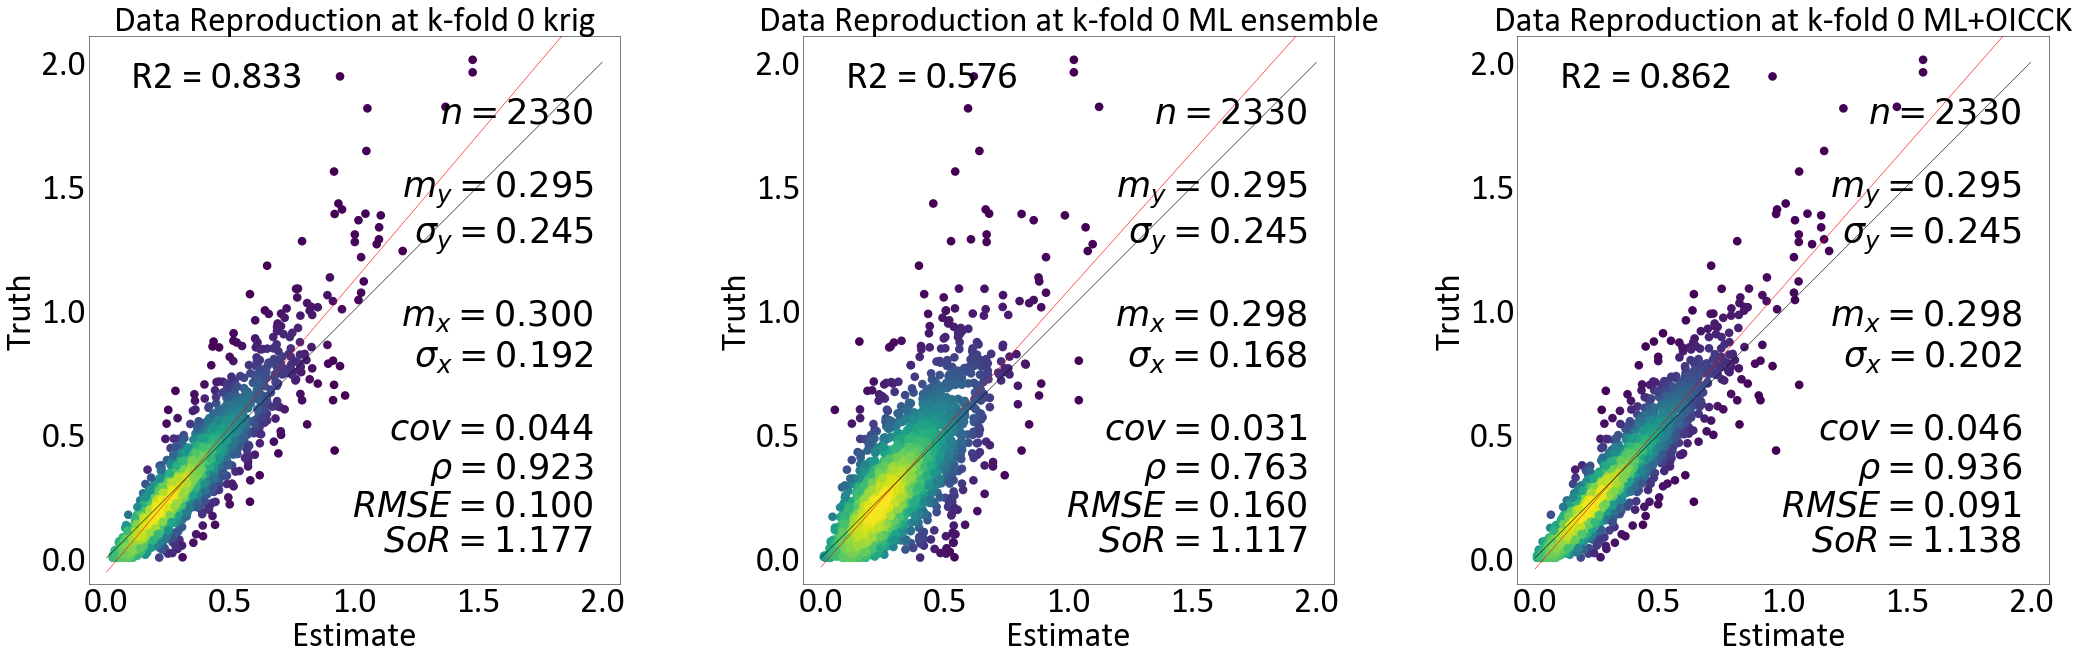

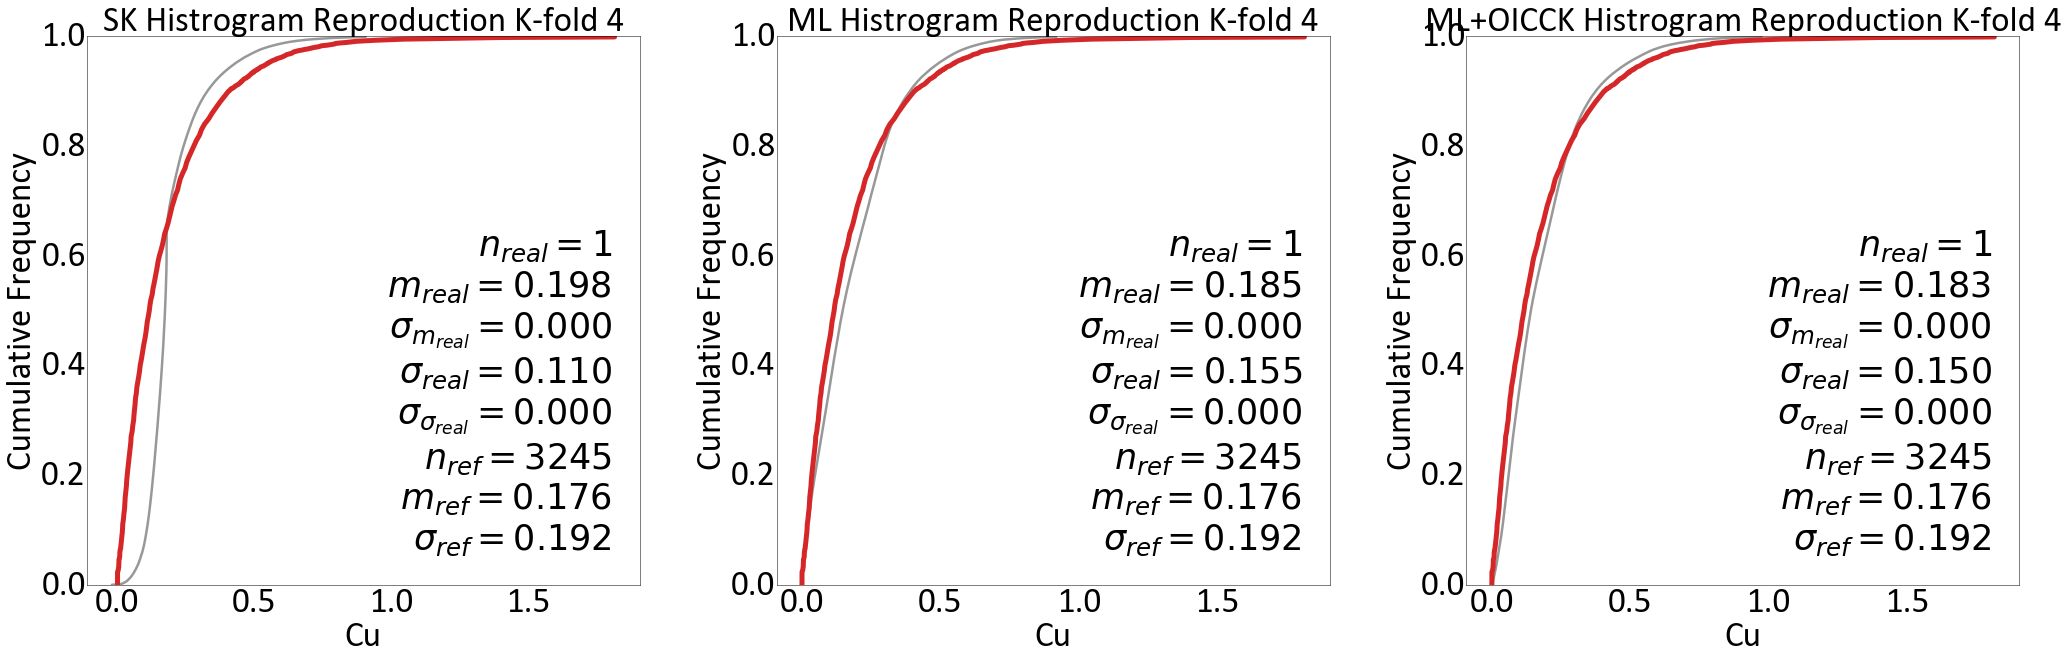

In [77]:
slinceno=14
vlim =(0,1)
pltlim = (0,2)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
gs.set_style('pt35')
krig_av_est = np.zeros(shape=(400000,1))
ML_av_est = np.zeros(shape=(400000,1))
ML_icck_av_est = np.zeros(shape=(400000,1))
idx_kfold = []
test_stack = []
for fold in range(1,5):
    i += 1
    testfile = gs.DataFile('./data/data_test_{}.dat'.format(fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
    pltdat_ml_icck = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
    declus = gs.DataFile('declus_ful.out'.format(fold))
    
    pltdat_ml.data['0'][pltdat_ml.data['0'] < 0] = 0
    pltdat_ml_icck.data['Estimate'][pltdat_ml_icck.data['Estimate'] < 0] = 0
    
    krig_av_est = krig_av_est +  pltdat_kt3dn.data['Estimate'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1) 
    ML_av_est = ML_av_est + pltdat_ml.data['0'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1)  
    ML_icck_av_est = ML_icck_av_est + pltdat_ml_icck.data['Estimate'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1) 
    
    pltdat_ml = gaussian_filter(pltdat_ml.data['0'],sigma = 8)
    pltdat_ml_icck.data['Estimate'] = gaussian_filter(pltdat_ml_icck.data['Estimate'],sigma =0)
    
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    idx_kfold[623*(i-1):623*i] = idx
    test_stack[623*(i-1):623*i] = testfile.data['Cu']
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]
    f, axes = plt.subplots(1, 3, figsize=(30, 10))
    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'prediction XY Krig Fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    #ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'prediction XY Krig')

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML prediction XY Ensemble Fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    #ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble')
    
    ax4 = gs.pixelplt(pltdat_ml_icck,var='Estimate',griddef=griddef,ax = axes[2],
                title = 'ML+OICCK prediction XY Fold {} '.format(fold),vlim=vlim, sliceno=slinceno)
    #ax4 = gs.locmap(datafl, ax=ax4,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/pixlpltxy_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(30, 10))

    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'prediction XY Krig Fold {}'.format(fold),vlim=vlim, sliceno=slinceno, orient = 'xz')
    #ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'prediction XY Krig', orient = 'xz')

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML prediction XY Ensemble Fold {}'.format(fold),vlim=vlim, sliceno=slinceno, orient = 'xz')
    #ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')

    ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,ax = axes[2],
                title = 'ML+OICCK Prediction XY Fold {}'.format(fold),vlim=vlim, sliceno=slinceno, orient = 'xz')
    #ax4 = gs.locmap(datafl, ax=ax4,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/pixlpltxz_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(30, 10))
    ax2 = gs.scatxval(pltdat_kt3dn.data['Estimate'][idx].values,testfile.data['Cu'],xlabel='Estimate', ylabel='Truth',ms=75,
        title = 'Data Reproduction at k-fold {} krig'.format(fold),dens=True,ax = axes[0],vlim=pltlim)
    axes[0].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(testfile.data['Cu'],pltdat_kt3dn.data['Estimate'][idx].values)),size=40)
    ax3 = gs.scatxval(pltdat_ml[idx],testfile.data['Cu'],xlabel='Estimate', ylabel='Truth',ms=75,
        title = 'Data Reproduction at k-fold {} ML ensemble'.format(fold),dens=True,ax = axes[1],vlim=pltlim)
    axes[1].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(testfile.data['Cu'],pltdat_ml[idx])),size=40)
    ax4 = gs.scatxval(np.asarray(pltdat_ml_icck.data['Estimate'])[idx],testfile.data['Cu'],xlabel='Estimate', ylabel='Truth',ms=75,
        title = 'Data Reproduction at k-fold {} ML+OICCK'.format(fold),dens=True,ax = axes[2],vlim=pltlim)
    axes[2].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(testfile.data['Cu'],np.asarray(pltdat_ml_icck.data['Estimate'])[idx])),size=40)
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/datarep_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    f, axes = plt.subplots(1, 3, figsize=(30, 10))
    ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],declus.data['Cu'],refwt = declus.data['Declustering Weight'],title = 'SK Histrogram Reproduction K-fold {}'.format(fold),
                        lw=5,ax=axes[0],griddef=griddef,nreal=1)


    ax3 = gs.histpltsim(pltdat_ml,declus.data['Cu'],refwt = declus.data['Declustering Weight'],title = 'ML Histrogram Reproduction K-fold {}'.format(fold),
                        lw=5,ax=axes[1],griddef=griddef,nreal=1)

    ax4 = gs.histpltsim(pltdat_ml_icck.data['Estimate'],declus.data['Cu'],refwt = declus.data['Declustering Weight'],title = 'ML+OICCK Histrogram Reproduction K-fold {}'.format(fold),
                        lw=5,ax=axes[2],griddef=griddef,nreal=1)
    

    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/histplt_{}_{}.png'.format(plt_extent,fold))
    plt.show()

krig_av_est = pd.DataFrame((krig_av_est/i),columns = ['Estimate'])
ML_av_est = pd.DataFrame((ML_av_est/i),columns = ['0'])
ML_icck_av_est = pd.DataFrame((ML_icck_av_est/i),columns = ['Estimate'])   
ML_av_est['0'] = gaussian_filter(ML_av_est['0'],sigma = 2)
ML_icck_av_est['Estimate'] = gaussian_filter(ML_icck_av_est['Estimate'],sigma =0)
test_stack = pd.DataFrame((test_stack),columns = ['Cu'])
idx_kfold = pd.DataFrame((idx_kfold),columns = ['0'])

test_stack = test_stack['Cu'][idx_kfold['0'] >= 0]
idx_kfold = idx_kfold['0'][idx_kfold['0'] >= 0]


f, axes = plt.subplots(1, 3, figsize=(30,10))

ax2 = gs.pixelplt(krig_av_est['Estimate'],ax = axes[0],griddef=griddef,
            title = 'prediction XY Krig Fold 0',vlim=vlim, sliceno=slinceno)
#ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'prediction XY Krig')

ax3 = gs.pixelplt(ML_av_est['0'],griddef=griddef,ax = axes[1],
            title = 'ML prediction XY ensemble Fold Zero',vlim=vlim, sliceno=slinceno)
#ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble')

ax4 = gs.pixelplt(ML_icck_av_est['Estimate'],griddef=griddef,ax = axes[2],
            title = 'ML+OICCK prediction XY Fold 0',vlim=vlim, sliceno=slinceno)
#ax4 = gs.locmap(datafl, ax=ax4,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble')
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/pixlpltxy_{}_{}.png'.format(plt_extent,0))
plt.show()

f, axes = plt.subplots(1, 3, figsize=(30,10))

ax2 = gs.pixelplt(krig_av_est['Estimate'],ax = axes[0],griddef=griddef,
            title = 'prediction XY Krig Fold 0',vlim=vlim, sliceno=slinceno, orient = 'xz')
#ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'prediction XY Krig', orient = 'xz')

ax3 = gs.pixelplt(ML_av_est['0'],griddef=griddef,ax = axes[1],
            title = 'ML prediction XY Ensemble Fold 0',vlim=vlim, sliceno=slinceno, orient = 'xz')
#ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')

ax4 = gs.pixelplt(ML_icck_av_est['Estimate'],griddef=griddef,ax = axes[2],
            title = 'ML+OICCK Prediction XY Ensemble Fold 0',vlim=vlim, sliceno=slinceno, orient = 'xz')
#ax4 = gs.locmap(datafl, ax=ax4,sliceno=slinceno, var = 'Cu' , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/pixlpltxz_{}_{}.png'.format(plt_extent,0))
plt.show()

f, axes = plt.subplots(1, 3, figsize=(30,10))
ax2 = gs.scatxval(krig_av_est['Estimate'][idx_kfold].values,test_stack,xlabel='Estimate', ylabel='Truth',ms=75,
    title = 'Data Reproduction at k-fold 0 krig'.format(fold),dens=True,ax = axes[0],vlim = pltlim)
axes[0].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(test_stack,krig_av_est['Estimate'][idx_kfold].values)),size=40)
ax3 = gs.scatxval(ML_av_est['0'][idx_kfold].values,test_stack,xlabel='Estimate', ylabel='Truth',ms=75,
    title = 'Data Reproduction at k-fold 0 ML ensemble'.format(fold),dens=True,ax = axes[1],vlim = pltlim)
axes[1].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(test_stack,ML_av_est['0'][idx_kfold].values)),size=40)
ax4 = gs.scatxval(ML_icck_av_est['Estimate'][idx_kfold].values,test_stack,xlabel='Estimate', ylabel='Truth',ms=75,
    title = 'Data Reproduction at k-fold 0 ML+OICCK'.format(fold),dens=True,ax = axes[2],vlim = pltlim)
axes[2].text(0.1,1.9,'R2 = {0:.3f}'.format(r2_score(test_stack,ML_icck_av_est['Estimate'][idx_kfold].values)),size=40)
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/datarep_{}_{}.png'.format(plt_extent,0))
plt.show()
f, axes = plt.subplots(1, 3, figsize=(30,10))
ax2 = gs.histpltsim(krig_av_est['Estimate'],declus.data['Cu'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[0],griddef=griddef,nreal=1,title = 'SK Histrogram Reproduction K-fold {}'.format(fold))


ax3 = gs.histpltsim(ML_av_est['0'],declus.data['Cu'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[1],griddef=griddef,nreal=1,title = 'ML Histrogram Reproduction K-fold {}'.format(fold))

ax4 = gs.histpltsim(ML_icck_av_est['Estimate'],declus.data['Cu'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[2],griddef=griddef,nreal=1,title = 'ML+OICCK Histrogram Reproduction K-fold {}'.format(fold))

plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/histplt_{}_{}.png'.format(plt_extent,0))
plt.show()

In [78]:
x,y,z = griddef.gridcoord()

In [79]:
krig_av_est['X'] = x
krig_av_est['Y'] = y
krig_av_est['Z'] = z
ML_av_est['X'] = x
ML_av_est['Y'] = y
ML_av_est['Z'] = z
ML_icck_av_est['X'] = x
ML_icck_av_est['Y'] = y
ML_icck_av_est['Z'] = z



In [80]:
gs.write_gslib(krig_av_est,'krig_Final_Est.out')
gs.write_gslib(ML_av_est,'ML_Final_Est.out')
gs.write_gslib(ML_icck_av_est,'ML+ICCK_Final_Est.out')

In [81]:
declus = gs.DataFile('declus_ful.out'.format(fold))
krig_swath = []
ml_swath = []
hybrid_swath = []
easting = []
truth_swath = []
swath_size = 200
for i in range(34400,36275,swath_size):
    easting.append(i)
    truth_swath.append(np.average(declus.data['Cu'][(declus.data['X'] >= i) & (declus.data['X'] < i+swath_size)],weights=declus.data['Declustering Weight'][(declus.data['X'] >= i) & (declus.data['X'] < i+swath_size)]))
    krig_swath.append(np.average(krig_av_est['Estimate'][(krig_av_est['X'] >= i) & (krig_av_est['X'] < i+swath_size)]))
    ml_swath.append(np.average(ML_av_est['0'][(ML_av_est['X'] >= i) & (ML_av_est['X'] < i+swath_size)]))
    hybrid_swath.append(np.average(ML_icck_av_est['Estimate'][(ML_icck_av_est['X'] >= i) & (ML_icck_av_est['X'] < i+swath_size)]))

In [82]:
truth_swath

[0.2257021352722732,
 0.15592757320349165,
 0.22102147277966652,
 0.25866514944849317,
 0.2488413680881948,
 0.22867998459262606,
 0.2460685263487296,
 0.15224915027185637,
 0.11004732033036019,
 0.0899438638041861]

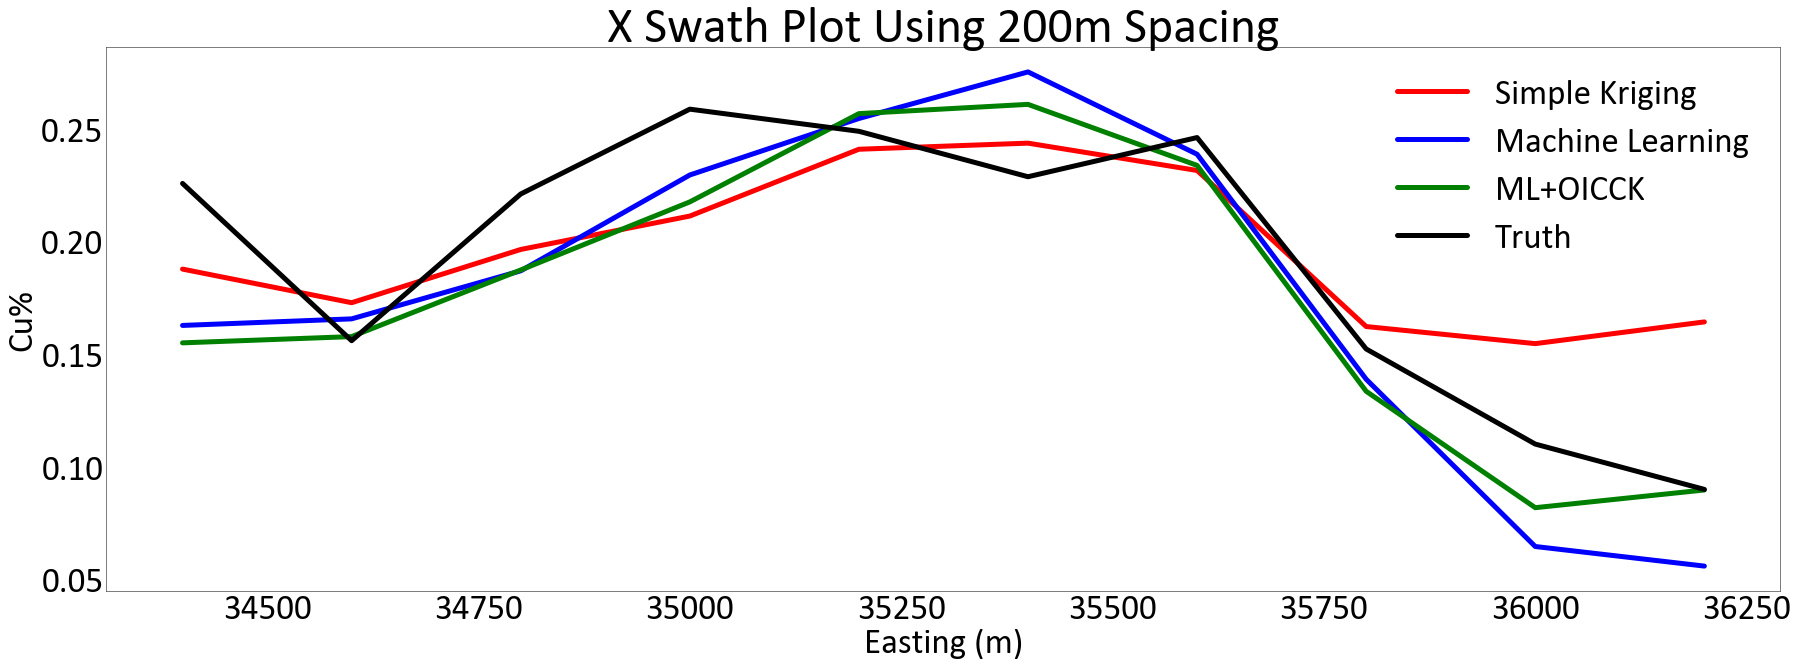

In [83]:
f, axes = plt.subplots(1, 1, figsize=(30, 10))
gs.set_style('pt35')
plt.rc('axes', titlesize=50)     # fontsize of the axes title
plt.rc('axes', labelsize=50)
axes.plot(easting,krig_swath,label = 'Simple Kriging',color = 'Red',lw=5)
axes.plot(easting,ml_swath,label = 'Machine Learning',color = 'Blue',lw=5)
axes.plot(easting,hybrid_swath,label = 'ML+OICCK',color = 'Green',lw=5)
axes.plot(easting,truth_swath,label = 'Truth',color = 'Black',lw=5)
axes.legend(loc = 'best')
plt.xlabel('Easting (m)')
plt.ylabel('Cu%')
plt.title('X Swath Plot Using {}m Spacing'.format(swath_size))
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/swathplt_xy_{}_{}.png'.format(plt_extent,0))
plt.show()



In [84]:
declus = gs.DataFile('declus_ful.out'.format(fold))
krig_swath = []
ml_swath = []
hybrid_swath = []
easting = []
truth_swath = []
swat_size = 200
for i in range(27400,28600,swat_size):
    easting.append(i)
    truth_swath.append(np.average(declus.data['Cu'][(declus.data['Y'] >= i) & (declus.data['Y'] < i+swat_size)],weights=declus.data['Declustering Weight'][(declus.data['Y'] >= i) & (declus.data['Y'] < i+swat_size)]))
    krig_swath.append(np.average(krig_av_est['Estimate'][(krig_av_est['Y'] >= i) & (krig_av_est['Y'] < i+swat_size)]))
    ml_swath.append(np.average(ML_av_est['0'][(ML_av_est['Y'] >= i) & (ML_av_est['Y'] < i+swat_size)]))
    hybrid_swath.append(np.average(ML_icck_av_est['Estimate'][(ML_icck_av_est['Y'] >= i) & (ML_icck_av_est['Y'] < i+swat_size)]))

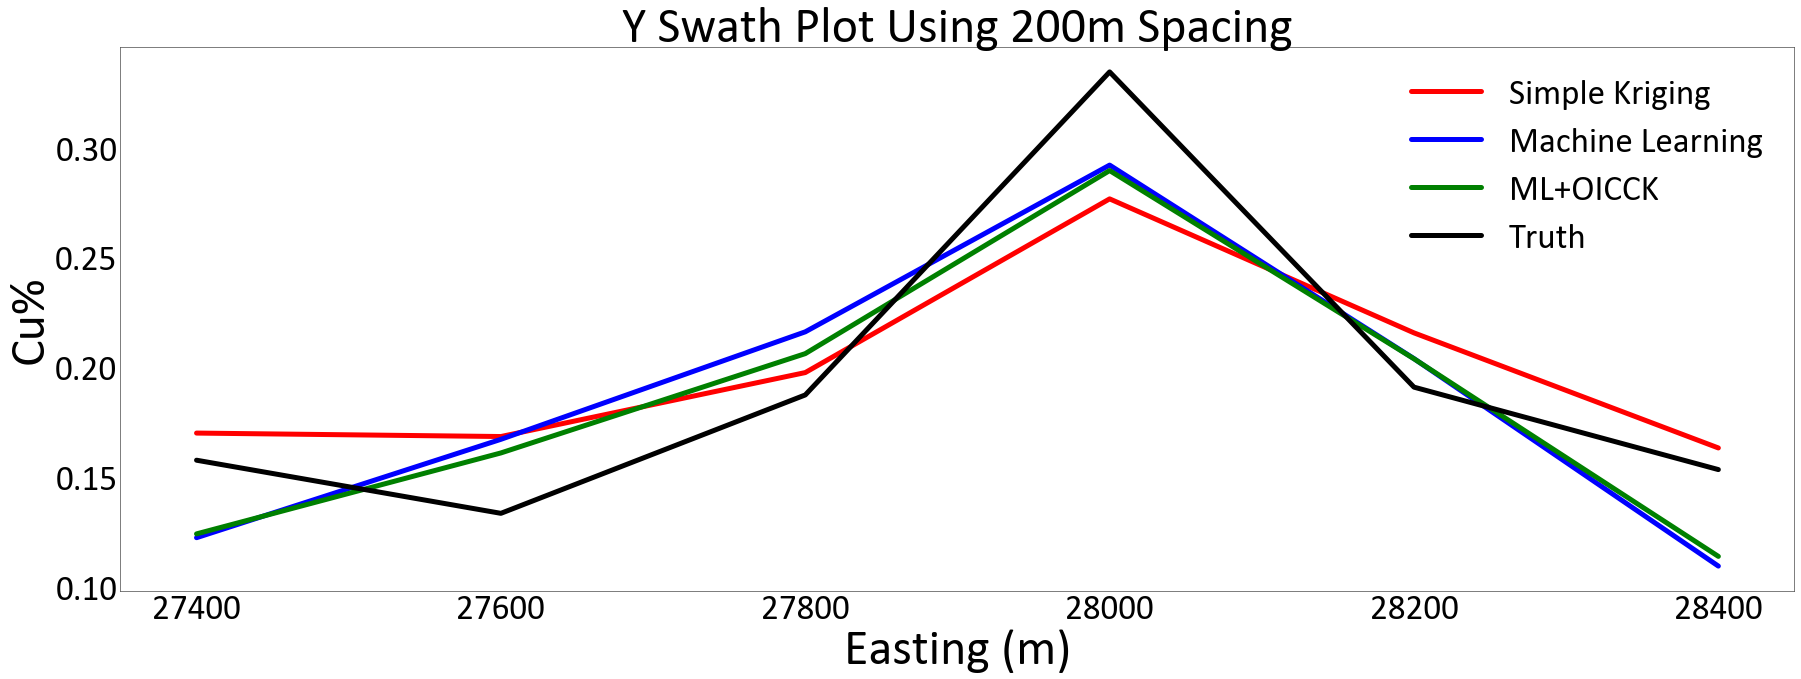

In [85]:
f, axes = plt.subplots(1, 1, figsize=(30, 10))
gs.set_style('pt35')
plt.rc('axes', titlesize=50)     # fontsize of the axes title
plt.rc('axes', labelsize=50)
axes.plot(easting,krig_swath,label = 'Simple Kriging',color = 'Red',lw=5)
axes.plot(easting,ml_swath,label = 'Machine Learning',color = 'Blue',lw=5)
axes.plot(easting,hybrid_swath,label = 'ML+OICCK',color = 'Green',lw=5)
axes.plot(easting,truth_swath,label = 'Truth',color = 'Black',lw=5)
axes.legend(loc = 'best')
plt.xlabel('Easting (m)')
plt.ylabel('Cu%')
plt.title('Y Swath Plot Using {}m Spacing'.format(swath_size))
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/swathplt_y_{}_{}.png'.format(plt_extent,0))
plt.show()



In [86]:
declus = gs.DataFile('declus_ful.out'.format(fold))
krig_swath = []
ml_swath = []
hybrid_swath = []
easting = []
truth_swath = []
swat_size = 100
for i in range(600,1200,swat_size):
    easting.append(i)
    truth_swath.append(np.average(declus.data['Cu'][(declus.data['Z'] >= i) & (declus.data['Z'] < i+swat_size)],weights=declus.data['Declustering Weight'][(declus.data['Z'] >= i) & (declus.data['Z'] < i+swat_size)]))
    krig_swath.append(np.average(krig_av_est['Estimate'][(krig_av_est['Z'] >= i) & (krig_av_est['Z'] < i+swat_size)]))
    ml_swath.append(np.average(ML_av_est['0'][(ML_av_est['Z'] >= i) & (ML_av_est['Z'] < i+swat_size)]))
    hybrid_swath.append(np.average(ML_icck_av_est['Estimate'][(ML_icck_av_est['Z'] >= i) & (ML_icck_av_est['Z'] < i+swat_size)]))

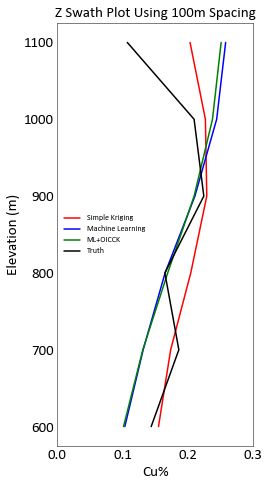

In [90]:
f, axes = plt.subplots(1, 1, figsize=(4, 7))
gs.set_style('pt15')
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)
axes.plot(krig_swath,easting,label = 'Simple Kriging',color = 'Red',lw=1.5)
axes.plot(ml_swath,easting,label = 'Machine Learning',color = 'Blue',lw=1.5)
axes.plot(hybrid_swath,easting,label = 'ML+OICCK',color = 'Green',lw=1.5)
axes.plot(truth_swath,easting,label = 'Truth',color = 'Black',lw=1.5)
axes.legend(loc = 6, prop={'size': 8})
plt.xticks(np.arange(0, 0.3+.1, 0.1))
plt.xlabel('Cu%')
plt.ylabel('Elevation (m)')
plt.title('Z Swath Plot Using {}m Spacing'.format(swat_size))
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/4-Chapter/swathplt_xz_{}_{}.png'.format(plt_extent,0))
plt.show()


In [88]:
np.average(declus.data['Cu'],weights=declus.data['Declustering Weight'])

0.17629257245124688

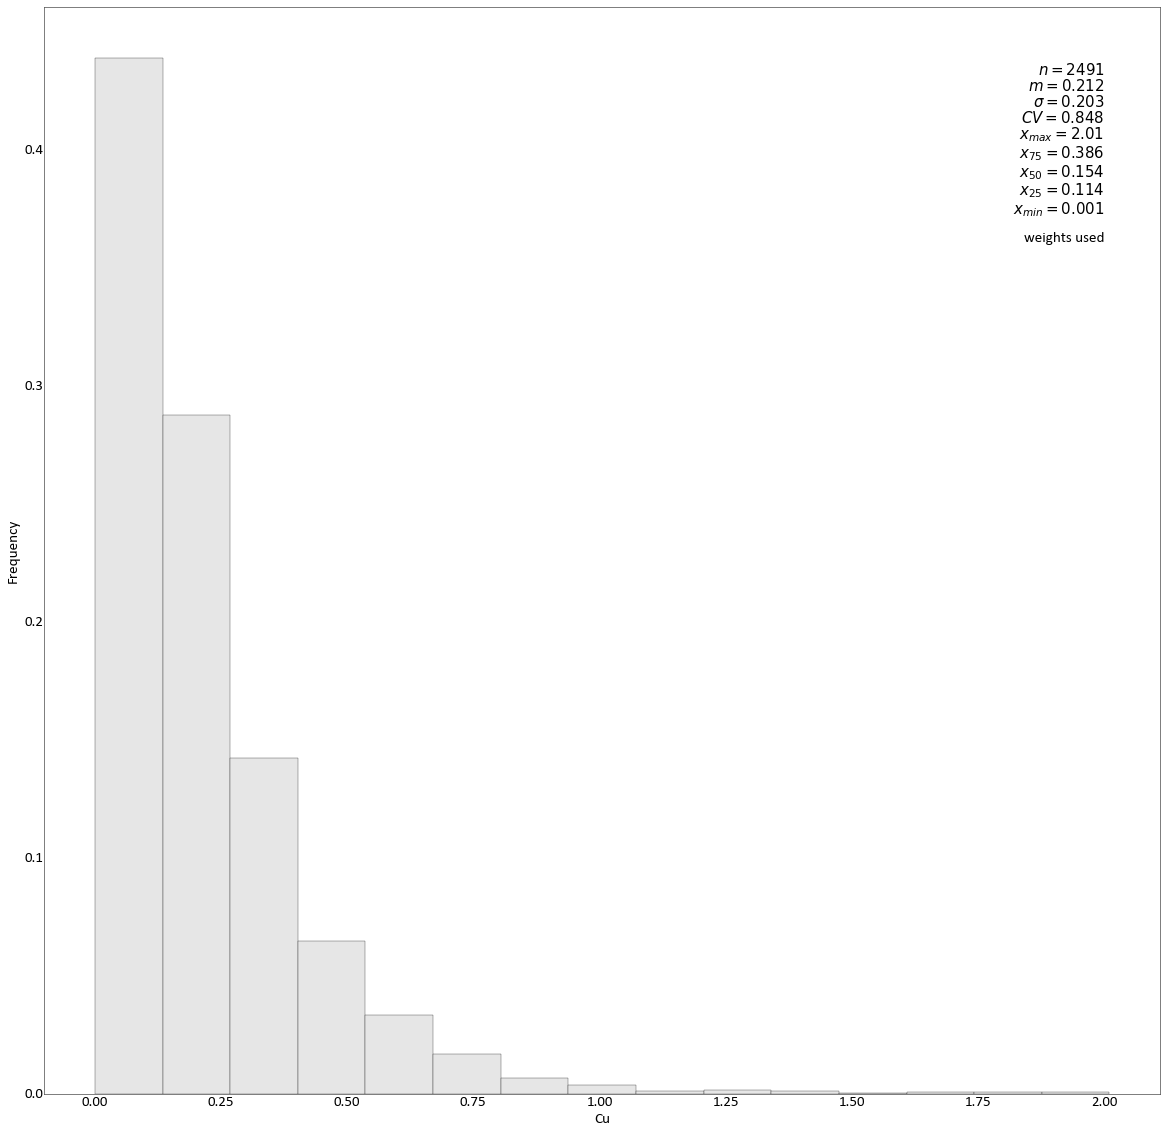

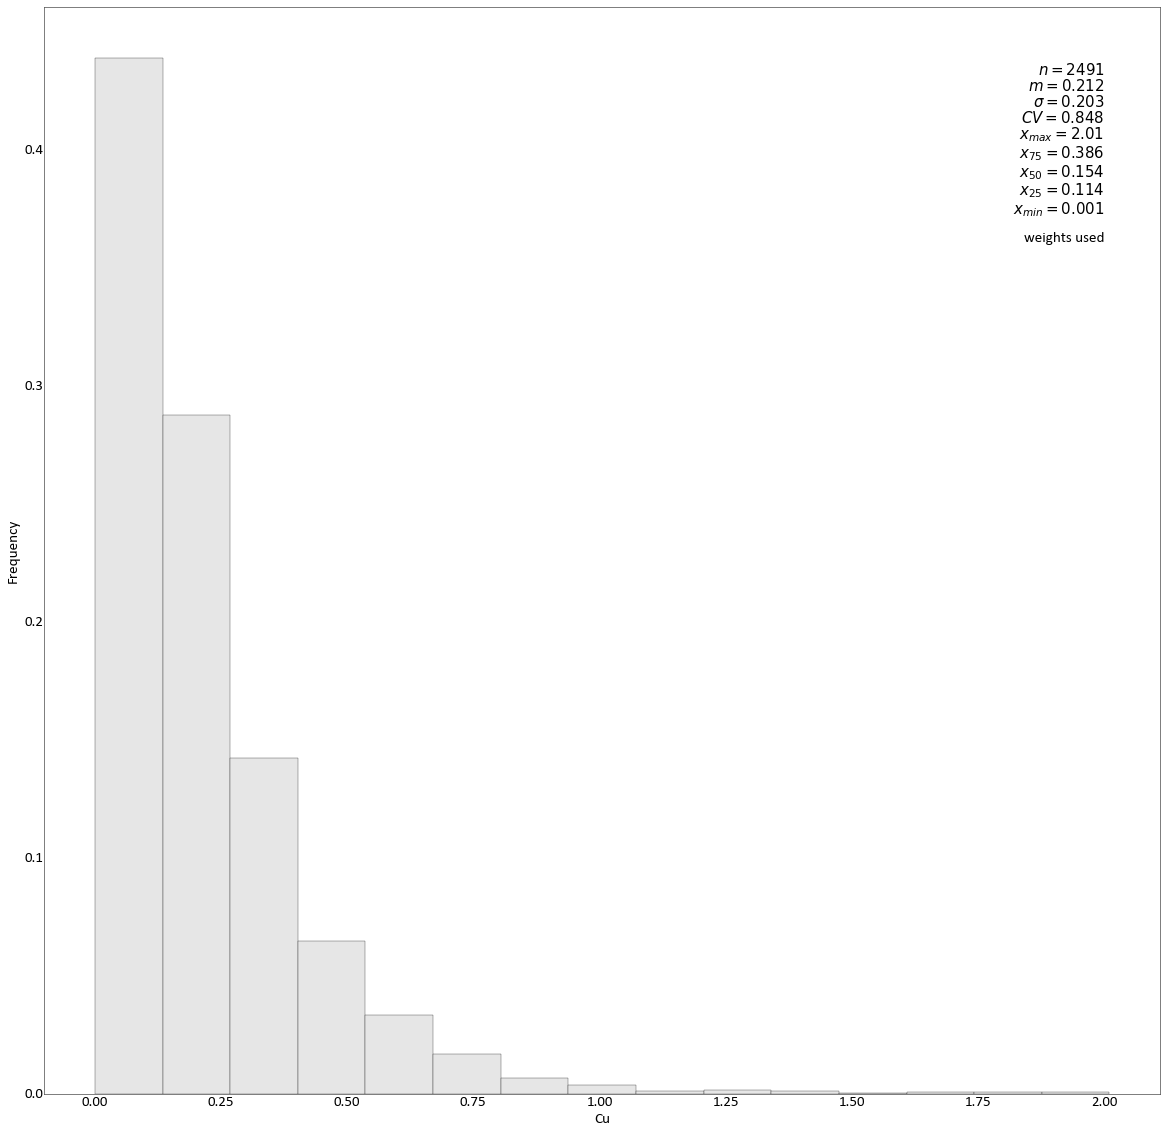

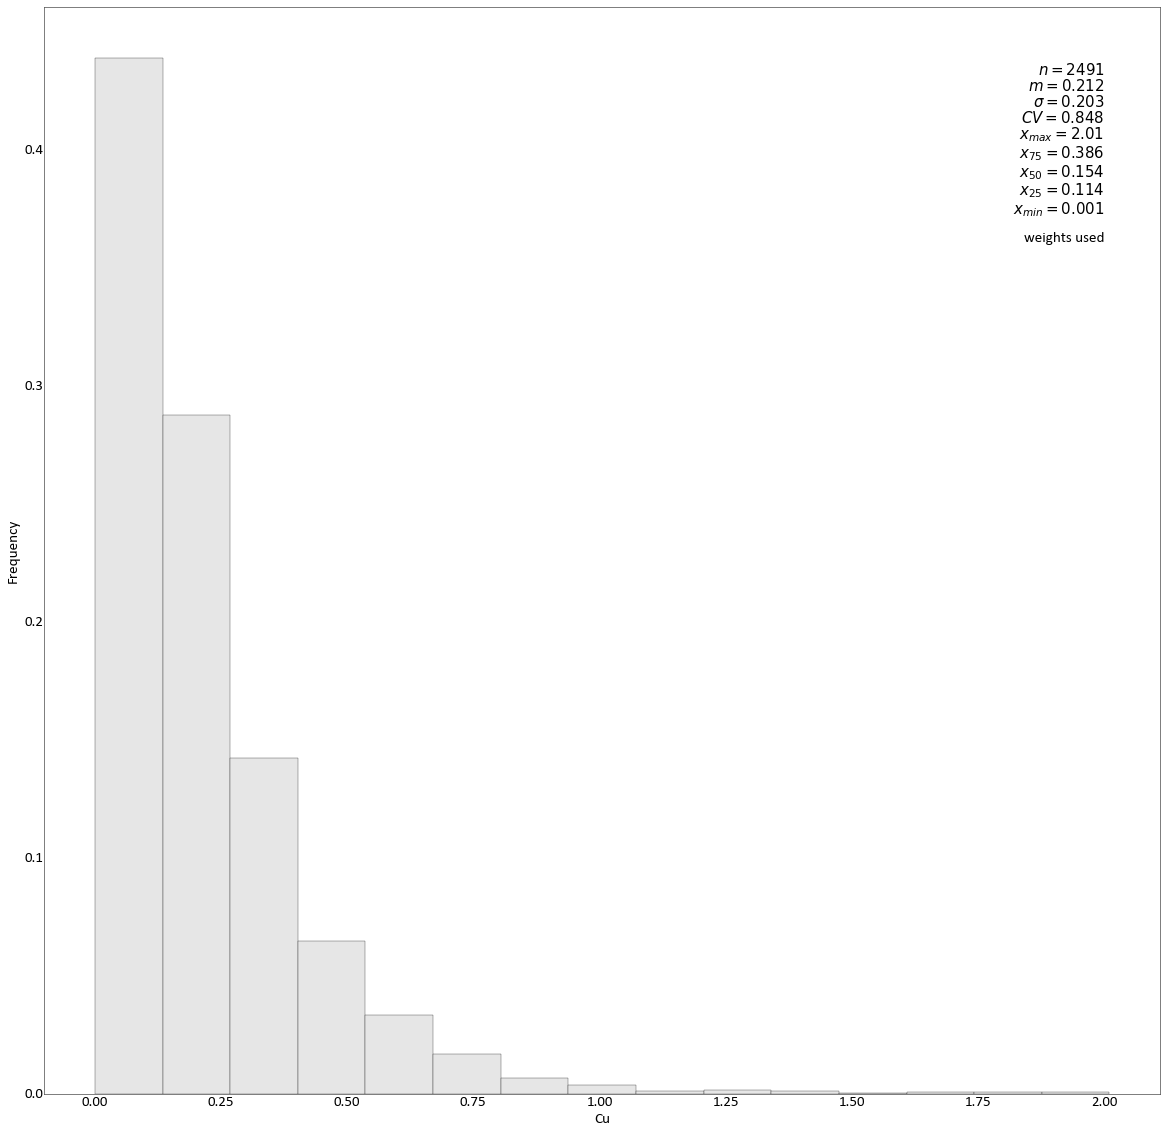

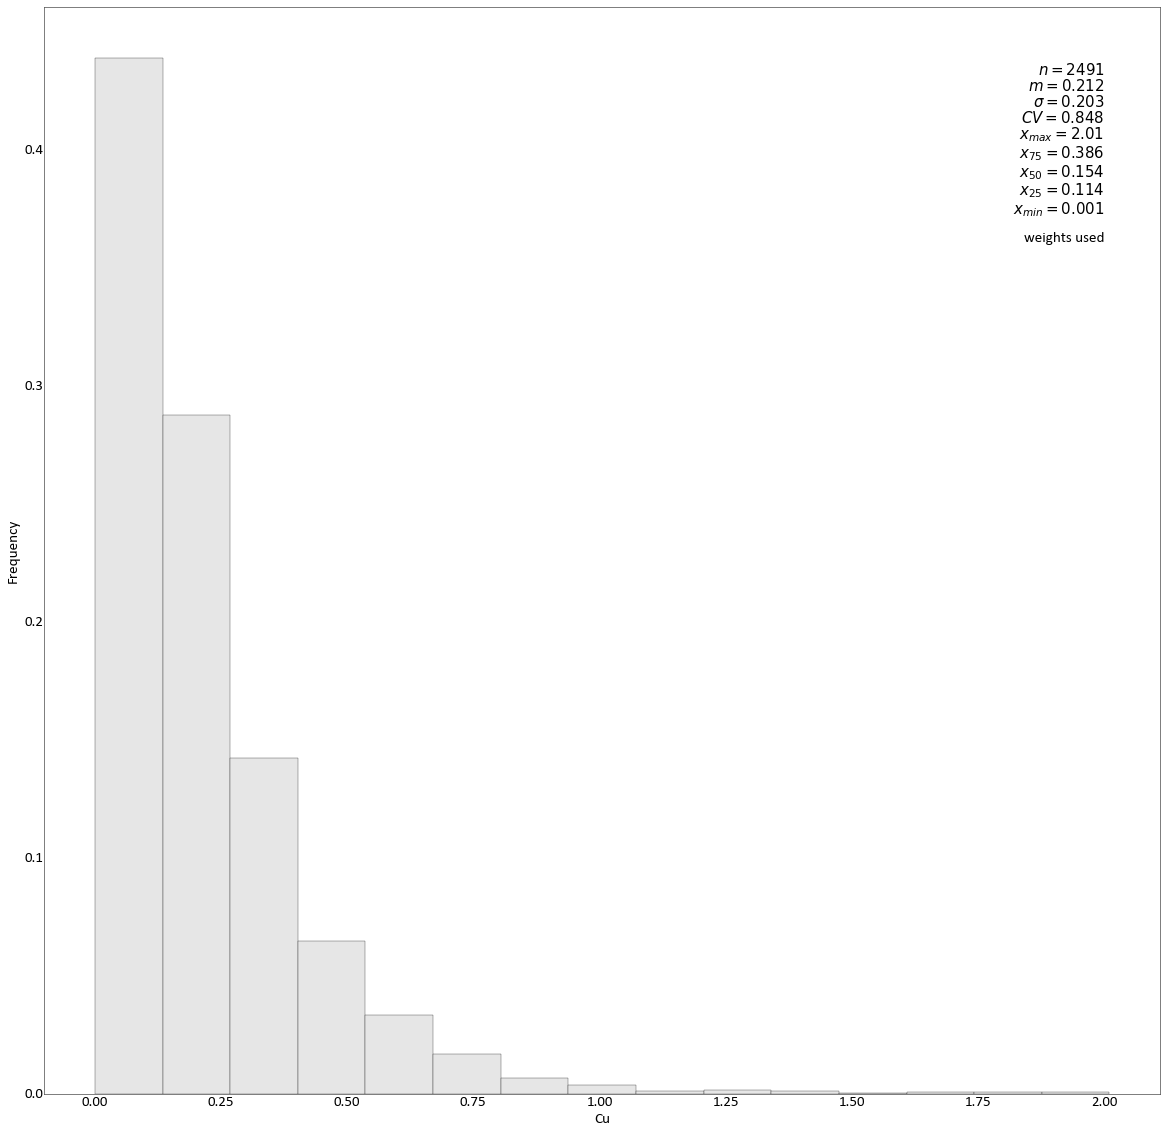

In [89]:
for i in range(1,5):
    declus = gs.DataFile('declus/declus_{}.out'.format(fold))
    gs.histplt(declus.data['Cu'],wt=declus.data['Declustering Weight'],figsize=(20,20),sigfigs=3)